# Ссылка на репозиторий - https://github.com/plooshka/personalized-offers-system#

# Разработка решения по персонализированному предложению товаров в интрнет-магазине «В один клик»


## Описание задачи

Интернет-магазин «В один клик» продаёт разные товары: для детей, для дома, мелкую бытовую технику, косметику и даже продукты. Отчёт магазина за прошлый период показал, что активность покупателей начала снижаться. Привлекать новых клиентов уже не так эффективно: о магазине и так знает большая часть целевой аудитории. Возможный выход — удерживать активность постоянных клиентов. Сделать это можно с помощью персонализированных предложений.


## Задача

Нашему отделу поручили разработать решение, которое позволит персонализировать предложения постоянным клиентам, чтобы увеличить их покупательскую активность. Для этого необходимо:

- промаркировать уровень финансовой активности постоянных покупателей. В компании принято выделять два уровня активности: «снизилась», если клиент стал покупать меньше товаров, и «прежний уровень»;
- собрать данные по клиентам по следующим группам:
    - признаки, которые описывают коммуникацию сотрудников компании с клиентом;
    - признаки, которые описывают продуктовое поведение покупателя;
    - признаки, которые описывают покупательское поведение клиента;
    - признаки, которые описывают поведение покупателя на сайте;

Далее мы:
- построим модель, которая предскажет вероятность снижения покупательской активности клиента в следующие три месяца;
- в исследование включим дополнительные данные финансового департамента о прибыльности клиента(какой доход каждый покупатель приносил компании за последние три месяца);
- используя данные модели и данные о прибыльности клиентов, выделим сегменты покупателей и разработаем для них персонализированные предложения.


## Описание данных

Данные разбиты на 4 таблицы:

1. `market_file.csv` - таблица, которая содержит данные о поведении покупателя на сайте, о коммуникациях с покупателем и его продуктовом поведении.
2. `market_money.csv` - таблица с данными о выручке, которую получает магазин с покупателя, то есть сколько покупатель всего потратил за период взаимодействия с сайтом.
3. `market_time.csv` - таблица с данными о времени (в минутах), которое покупатель провёл на сайте в течение периода
4. `money.csv` - таблица с данными о среднемесячной прибыли продавца за последние 3 месяца: какую прибыль получает магазин от продаж каждому покупателю


## Предварительный план

- для начала откроем наши наборы данных, посмотрим что лежит внутри
- проведем предобработку данных, где приведем данные к необходимым типам данных, найдем пропуски и решим как с ними работать, далее мы исследуем наш набор данных на наличие явных и неявных дубликатов
- при необходимости рассчитаем дополнительные параметры для проведения анализа
- проведем исследовательский анализ данных
- проведем корреляционный анализ признаков в наборах данных
- соберем необходимые пайплайны
- найдем лучшую модель, которая предскажет вероятность снижения покупательской активности
- выделим сегмент(ы) покупателей, проанализируем его(их)
- предложим, как увеличить покупательскую активность в выделенных сегментах


In [ ]:
# необходимые для работы библиотеки 

!pip install scikit-learn==1.1.3 -q
!pip install seaborn==0.13.2 -q
!pip install matplotlib==3.5.2 -q
!pip install phik -q
!pip install shap -q

import pandas as pd

import matplotlib.pyplot as plt

import seaborn as sns

from phik.report import plot_correlation_matrix

import shap

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import precision_score, recall_score, confusion_matrix, roc_auc_score

RANDOM_STATE = 42
TEST_SIZE = 0.25

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
scipy 1.9.1 requires numpy<1.25.0,>=1.18.5, but you have numpy 2.0.2 which is incompatible.
numba 0.56.0 requires numpy<1.23,>=1.18, but you have numpy 2.0.2 which is incompatible.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
numba 0.56.0 requires numpy<1.23,>=1.18, but you have numpy 1.24.4 which is incompatible.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
contourpy 1.3.0 requires numpy>=1.23, but you have numpy 1.22.4 which is incompatible.


## Загрузка данных

Создадим функцию для отображения основных характеристик датафрейма.

In [2]:
def df_overview(df):
    """
    Функция для первичного анализа датафрейма
    
    Параметры:
    df (pandas.DataFrame) - входной датафрейм
    
    Возвращает:
    None (выводит информацию)
    """
    
    # Размер датафрейма
    print(f"\n1. Размер датафрейма: {df.shape[0]} строк, {df.shape[1]} столбцов")

    # Общая информация
    print("\n2. Общая информация о датафрейме:")
    df.info()

    # Проверка на пропуски
    print("\n3. Пропущенные значения:")
    print(df.isnull().sum())

Загрузим каждый датафрейм в отдельную переменную и выведем его основные характеристики.

In [3]:
# загрузка датафрейма, который содержит данные о поведении покупателя на сайте, о коммуникациях с покупателем и его продуктовом поведении
market_file_df = pd.read_csv('/datasets/market_file.csv')
df_overview(market_file_df)
market_file_df.sample(5)


1. Размер датафрейма: 1300 строк, 13 столбцов

2. Общая информация о датафрейме:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   Покупательская активность            1300 non-null   object 
 2   Тип сервиса                          1300 non-null   object 
 3   Разрешить сообщать                   1300 non-null   object 
 4   Маркет_актив_6_мес                   1300 non-null   float64
 5   Маркет_актив_тек_мес                 1300 non-null   int64  
 6   Длительность                         1300 non-null   int64  
 7   Акционные_покупки                    1300 non-null   float64
 8   Популярная_категория                 1300 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  Неоплаченные_п

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
1163,216511,Прежний уровень,стандарт,да,4.6,4,704,0.11,Домашний текстиль,4,4,5,10
407,215755,Прежний уровень,стандарт,да,4.4,4,216,0.18,Техника для красоты и здоровья,2,3,5,13
633,215981,Прежний уровень,стандарт,да,3.8,4,302,0.16,Товары для детей,5,1,5,8
278,215626,Снизилась,стандарт,да,2.7,5,171,0.95,Товары для детей,1,1,2,2
665,216013,Прежний уровень,стандарт,нет,6.1,3,312,0.47,Домашний текстиль,3,1,2,12


Датасет загружен успешно. Пять случайных строк выглядят ожидаемо, пропуски отсутствуют, значения данных хранящиеся в столбцах соответствуют типам данных своих столбцов. Общий стиль именования отсутствует, необходимо будет устранить это на этапе предобработки данных.

Загрузим следующий датасет.

In [4]:
# загрузка датафрейма с данными о выручке, которую получает магазин с покупателя
market_money_df = pd.read_csv('/datasets/market_money.csv')
df_overview(market_money_df)
market_money_df.sample(5)


1. Размер датафрейма: 3900 строк, 3 столбцов

2. Общая информация о датафрейме:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   Период   3900 non-null   object 
 2   Выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB

3. Пропущенные значения:
id         0
Период     0
Выручка    0
dtype: int64


,id,Период,Выручка
438,215494,текущий_месяц,5784.5
3754,216599,препредыдущий_месяц,4428.0
3283,216442,предыдущий_месяц,3829.0
1731,215925,предыдущий_месяц,4458.0
1371,215805,предыдущий_месяц,4126.0


Датасет загружен успешно. Пять случайных строк выглядят ожидаемо, пропуски отсутствуют, значения данных хранящиеся в столбцах соответствуют типам данных своих столбцов. Общий стиль именования отсутствует, необходимо будет устранить это на этапе предобработки данных.

Загрузим следующий датасет.

In [5]:
# загрузка датафрейма с данными о времени (в минутах), которое покупатель провёл на сайте в течение периода
market_time_df = pd.read_csv('/datasets/market_time.csv')
df_overview(market_time_df)
market_time_df.sample(5)


1. Размер датафрейма: 2600 строк, 3 столбцов

2. Общая информация о датафрейме:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   Период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB

3. Пропущенные значения:
id        0
Период    0
минут     0
dtype: int64


,id,Период,минут
2534,216615,предыдцщий_месяц,11
2278,216487,предыдцщий_месяц,19
132,215414,текущий_месяц,9
1617,216156,текущий_месяц,16
1418,216057,предыдцщий_месяц,8


Датасет загружен успешно. Пять случайных строк выглядят ожидаемо, пропуски отсутствуют, значения данных хранящиеся в столбцах соответствуют типам данных своих столбцов. Общий стиль именования отсутствует, необходимо будет устранить это на этапе предобработки данных.

Загрузим последний датасет.

In [6]:
# загрузка датафрейма с данными о среднемесячной прибыли продавца за последние 3 месяца
money_df = pd.read_csv('/datasets/money.csv', sep=';', decimal=',')
df_overview(money_df)
money_df.sample(5)


1. Размер датафрейма: 1300 строк, 2 столбцов

2. Общая информация о датафрейме:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       1300 non-null   int64  
 1   Прибыль  1300 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 20.4 KB

3. Пропущенные значения:
id         0
Прибыль    0
dtype: int64


,id,Прибыль
185,215533,5.05
126,215474,4.59
46,215394,3.90
842,216190,4.23
1042,216390,2.85


Датасет загружен успешно. Пять случайных строк выглядят не слишком ожидаемо - непонятно какие имеют еденицы измерения значения в столбце **"Прибыль"**. Пропуски отсутствуют. Общий стиль именования отсутствует, необходимо будет устранить это на этапе предобработки данных.

Все данные загружены успешно, первичный обзор проведен успешно. На этапе предобработки мы исправим все встреченные проблемы при первичном обзоре, а также выполним остальные пункты предобработки данных.

##  Предобработка данных

Начнем по порядку с датафрейма `market_file_df` о поведении покупателя на сайте, о коммуникациях с покупателем и его продуктовом поведении. Переименуем столбцы, проверим датафрейм на явные дубликаты, проверим на неявные дубликаты(по сумме ключевых параметров, если необходимо), посмотрим на уникальные значения в категориальных столбцах, при необходимости устраним проблемы. После всех корректировок проведем повторную проверку на наличие явных дубликатов.

In [7]:
market_file_df.sample(5)

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
226,215574,Снизилась,премиум,да,3.0,4,951,0.22,Домашний текстиль,2,5,2,6
953,216301,Прежний уровень,премиум,да,3.9,5,410,0.20,Косметика и аксесуары,3,1,5,14
981,216329,Прежний уровень,премиум,да,5.5,4,894,0.99,Техника для красоты и здоровья,4,0,7,11
800,216148,Прежний уровень,стандарт,нет,3.6,5,180,0.32,Домашний текстиль,4,4,1,13
136,215484,Снизилась,премиум,нет,2.9,5,448,0.23,Товары для детей,4,2,6,3


Начнем с приведения наименований столбцов к общему стилю именования.

In [8]:
# Переименуем столбец "id" в "номер_покупателя"
market_file_df.rename(
    columns=
    {'id': 'номер_покупателя'}, 
    inplace=True
    )

# Переведем все названия столбцов в нижний регистр
market_file_df.columns = map(str.lower, market_file_df.columns)

# Проведем удаление лишних пробелов в названиях столбцов на всякий случай
market_file_df.columns = market_file_df.columns.str.strip()

# Заменим пробелы в названиях столбцов на подчеркивания
market_file_df.columns = market_file_df.columns.str.replace(' ', '_')

market_file_df.sample(5)

,номер_покупателя,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит
1088,216436,Прежний уровень,стандарт,да,4.6,4,785,0.24,Мелкая бытовая техника и электроника,2,1,6,13
264,215612,Снизилась,премиум,нет,4.4,3,255,0.94,Домашний текстиль,3,5,7,7
729,216077,Прежний уровень,премиум,да,4.9,4,763,0.25,Мелкая бытовая техника и электроника,2,2,2,17
350,215698,Снизилась,стандарт,да,3.5,4,685,0.89,Техника для красоты и здоровья,2,9,3,3
558,215906,Снизилась,стандарт,да,5.2,5,373,0.14,Домашний текстиль,1,4,3,8


Теперь наш датафрейм выглядит надлежащим образом. 

Сперва проверим датафрейм на наличие явных дубликатов.

In [9]:
market_file_df.duplicated().sum()

0

На стадии первичного знакомства с данными в этом датасете не было выявлено проблем с пропусками и типами данных. Поэтому приступим к поиску неявных дубликатов в категориальных столбцах. Для этого напишем функцию, которая будет выводить количество уникальных значений во всех категориальных столбцах датафрейма.

In [10]:
def show_uniq_values_in_categorical_columns(df):
    for col in df.select_dtypes(include=['object']):
        print(df[col].value_counts())
        print()
        

In [11]:
show_uniq_values_in_categorical_columns(market_file_df)

Прежний уровень    802
Снизилась          498
Name: покупательская_активность, dtype: int64

стандарт     914
премиум      376
стандартт     10
Name: тип_сервиса, dtype: int64

да     962
нет    338
Name: разрешить_сообщать, dtype: int64

Товары для детей                        330
Домашний текстиль                       251
Косметика и аксесуары                   223
Техника для красоты и здоровья          184
Мелкая бытовая техника и электроника    174
Кухонная посуда                         138
Name: популярная_категория, dtype: int64



В столбце **"тип_сервиса"** есть неявный дубликат с одинаковым по смыслу значению, но разным по написанию - "стандарт" и "стандартт". Исправим это.

In [12]:
market_file_df['тип_сервиса'] = market_file_df['тип_сервиса'].str.replace('стандартт', 'стандарт')
market_file_df['тип_сервиса'].value_counts()

стандарт    924
премиум     376
Name: тип_сервиса, dtype: int64

Теперь неявные дубликаты в столбце **"тип_сервиса"** отсутствуют. Далее посмотрим какое количетсво у нас имеется уникальных значений в столбце **"номер_покупателя"**, совпадает ли оно с количеством строк. И проверим еще раз весь датафрейм на наличие явных дубликатов.

In [13]:
market_file_df['номер_покупателя'].nunique()

1300

In [14]:
market_file_df.duplicated().sum()

0

После всех корректировок явные дубликаты не появились. Для данного этапа наш датафрейм приведен в необходимое состояние.

Теперь перейдем к следующему датасету `market_money_df` с данными о выручке, которую получает магазин с покупателя. Будем работать с ним по такому же алгоритму, что и с предыдущим датасетом.

In [15]:
market_money_df.sample(5)

,id,Период,Выручка
2680,216241,текущий_месяц,5415.6
3611,216551,текущий_месяц,5163.6
2183,216075,препредыдущий_месяц,5433.0
1636,215893,предыдущий_месяц,4936.5
3118,216387,препредыдущий_месяц,5355.0


In [16]:
# Переименуем столбец "id" в "номер_покупателя"
market_money_df.rename(
    columns=
    {'id': 'номер_покупателя'}, 
    inplace=True
    )

# Переведем все названия столбцов в нижний регистр
market_money_df.columns = map(str.lower, market_money_df.columns)

# Проведем удаление лишних пробелов в названиях столбцов на всякий случай
market_money_df.columns = market_money_df.columns.str.strip()

market_money_df.sample(5)

,номер_покупателя,период,выручка
959,215667,препредыдущий_месяц,4544.0
698,215580,текущий_месяц,5635.8
3223,216422,предыдущий_месяц,4988.5
3020,216354,текущий_месяц,4943.1
2553,216199,препредыдущий_месяц,5323.0


In [17]:
market_money_df.duplicated().sum()

0

In [18]:
show_uniq_values_in_categorical_columns(market_money_df)

предыдущий_месяц       1300
текущий_месяц          1300
препредыдущий_месяц    1300
Name: период, dtype: int64



In [19]:
market_money_df['номер_покупателя'].nunique()

1300

На стадии первичного знакомства с данными в этом датасете не было выявлено проблем с пропусками и типами данных. C категориальными значениями тут тоже все в порядке. Так как никаких манипуляций с данными мы не производили, то и повторный поиск явных дубликатов проводить не будем.

Переходим к следующему датафрейму `market_time_df` о времени, проведенном пользователем на сайте. Работать с ним мы будем по такому же алгоритму, что и с предыдущими датасетами.

In [20]:
market_time_df.sample(5)

,id,Период,минут
133,215414,предыдцщий_месяц,13
1253,215974,текущий_месяц,7
791,215743,текущий_месяц,8
1757,216226,текущий_месяц,12
436,215566,текущий_месяц,14


In [21]:
# Переименуем столбец "id" в "номер_покупателя"
market_time_df.rename(
    columns=
    {'id': 'номер_покупателя'}, 
    inplace=True
    )

# Переведем все названия столбцов в нижний регистр
market_time_df.columns = map(str.lower, market_time_df.columns)

# Проведем удаление лишних пробелов в названиях столбцов на всякий случай
market_time_df.columns = market_time_df.columns.str.strip()

market_time_df.sample(5)

,номер_покупателя,период,минут
1933,216314,предыдцщий_месяц,10
2148,216422,предыдцщий_месяц,15
872,215784,предыдцщий_месяц,21
2276,216486,текущий_месяц,11
134,215415,текущий_месяц,9


In [22]:
market_time_df.duplicated().sum()

0

In [23]:
show_uniq_values_in_categorical_columns(market_time_df)

текущий_месяц       1300
предыдцщий_месяц    1300
Name: период, dtype: int64



Исправим опечатку в значении периода для удобочитаемости.

In [24]:
market_time_df['период'] = market_time_df['период'].str.replace('предыдцщий_месяц', 'предыдущий_месяц') 
market_time_df['период'].value_counts()

предыдущий_месяц    1300
текущий_месяц       1300
Name: период, dtype: int64

In [25]:
market_time_df['номер_покупателя'].nunique()

1300

На стадии первичного знакомства с данными в этом датасете не было выявлено проблем с пропусками и типами данных. C категориальными значениями тут тоже все в порядке. Так как никаких манипуляций с данными мы не производили, то и повторный поиск явных дубликатов проводить не будем.

Переходим к последнему датафрейму `money_df` с данными о среднемесячной прибыли продавца за последние 3 месяца. Работать с ним мы будем по такому же алгоритму, что и с предыдущими датасетами.

In [26]:
money_df.sample(5)

,id,Прибыль
548,215896,3.73
203,215551,4.08
746,216094,2.39
1148,216496,4.52
1029,216377,5.00


In [27]:
# Переименуем столбец "id" в "номер_покупателя"
money_df.rename(
    columns=
    {'id': 'номер_покупателя'}, 
    inplace=True
    )

# Переведем все названия столбцов в нижний регистр
money_df.columns = map(str.lower, money_df.columns)

# Проведем удаление лишних пробелов в названиях столбцов на всякий случай
money_df.columns = money_df.columns.str.strip()

money_df.sample(5)

,номер_покупателя,прибыль
815,216163,3.89
808,216156,3.59
1253,216601,4.87
895,216243,2.79
1000,216348,4.89


При первичном знакомстве мы выявили проблему с типом данных в столбце "прибыль" для этого датафрейма. На данный момент он представлен строковым типом, а должен быть числовым с дробной частью после запятой. Исправим это с помощью функции *pd.to_numeric()*. Перед преобразованием заменим все запятые на точки и на всякий случай удалим лишние пробелы(если такие есть) с обеих сторон строки.

In [28]:
# money_df['прибыль'] = money_df['прибыль'].str.replace(',', '.').str.strip()
# money_df['прибыль']

In [29]:
# money_df['прибыль'] = pd.to_numeric(money_df['прибыль'])

In [30]:
money_df.info()
money_df.sample(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   номер_покупателя  1300 non-null   int64  
 1   прибыль           1300 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 20.4 KB


,номер_покупателя,прибыль
137,215485,5.41
724,216072,3.27
1106,216454,2.90
1015,216363,3.06
871,216219,3.77


In [31]:
money_df['номер_покупателя'].nunique()

1300

Этап предобработки выполнен успешно:

1. Датафреймы приведены к общей форме именования столбцов
2. Типы данных столбцов соответсвуют значениям хранящимся в них
3. Явные дубликаты отсутствуют
4. Неявные дубликаты для категориальных переменных обработаны

Далее можно приступить к исследовательскому анализу данных.



## Исследовательский анализ данных

Для упрощения проведения анализа, напишем собственные функции, чтобы избежать дублирования кода.

In [32]:
def numeric_visualization(df, numeric_columns):
    """
    Функция для визуализации описательной статистики,
    графиков 'ящик с усами' и гистограмм распределения
    
    Параметры:
    df (pandas.DataFrame) - входной датафрейм
    numeric_columns (list) - список числовых столбцов для анализа
    
    Возвращает:
    None (выводит графики и статистику)
    """
    for col in numeric_columns:
        # Описательная статистика
        print("\nОписательная статистика:\n")
        print(df[col].describe())
        
        # График 'ящик с усами'
        plt.figure(figsize=(15, 2))
        sns.boxplot(data=df[col], orient='h')
        plt.title(f'Ящик с "усами" для столбца {col}')
        plt.xlabel('Значения')
        plt.ylabel('Признаки')
        plt.grid()
        plt.show();
        
        # Гистограмма распределения
        plt.figure(figsize=(10, 5))
        sns.histplot(df[col], kde=True, color='skyblue')
        plt.title(f'Гистограмма распределения для столбца {col}')
        plt.xlabel(col)
        plt.ylabel('Частота')
        plt.grid()
        plt.show();
        
        # Статистика выбросов
        print("\nСтатистика выбросов:\n")
        q1 = df[col].quantile(0.25)
        q3 = df[col].quantile(0.75)
        iqr = q3 - q1
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr
        outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
        print(f"{col}: {len(outliers)} выбросов\n")
        # разделитель
        print("-" * 150)

def categorical_visualization(df, categorical_columns):
    """
    Функция для визуализации категориальных данных
    
    Параметры:
    df (pandas.DataFrame) - входной датафрейм
    categorical_columns (list) - список категориальных столбцов для анализа
    
    Возвращает:
    None (выводит графики и статистику)
    """
    for col in categorical_columns:
        # Статистика по уникальным значениям
        print("\nСтатистика уникальных значений:\n")
        print(df[col].value_counts(dropna=False))
        print(f"Количество уникальных значений: {df[col].nunique()}")
        print("-"*40)
        
        
        # График перевернутой столбчатой диаграммы
        plt.figure(figsize=(15, 2))
        sns.barplot(x=df[col].value_counts().values, 
                    y=df[col].value_counts().index, 
                    )
        plt.title(f'Перевернутая столбчатая диаграмма для столбца {col}')
        plt.xlabel('Количество')
        plt.ylabel(col)
        plt.grid()
        plt.show()
        
        # Статистика баланса классов
        class_balance = df[col].value_counts()
        plt.figure(figsize=(15, 2))
        plt.pie(class_balance, autopct='%1.1f%%', startangle=90, labels=class_balance.index)
        plt.title(f'Соотношение значений {col}')
        plt.xlabel('Процент от общего числа')
        plt.grid()
        plt.show()
        print("-"*150)




Исследуем `market_file_df`, который содержит данные о поведении покупателя на сайте, о коммуникациях с покупателем и его продуктовом поведении. Выделим списки числовых и категориальных признаков, которые будем анализировать.

In [33]:
# выберем категориальные признаки
cat_cols_market_file_df = [col for col in market_file_df.columns if market_file_df[col].dtype=="O"]

# выберем числовые признаки
num_cols_market_file_df = [col for col in market_file_df.columns if market_file_df[col].dtype in ["int64", "float64"]]

# удалим уникальный номер покупателя
num_cols_market_file_df.remove('номер_покупателя')

print(cat_cols_market_file_df,'\n', num_cols_market_file_df)


['покупательская_активность', 'тип_сервиса', 'разрешить_сообщать', 'популярная_категория'] 
 ['маркет_актив_6_мес', 'маркет_актив_тек_мес', 'длительность', 'акционные_покупки', 'средний_просмотр_категорий_за_визит', 'неоплаченные_продукты_штук_квартал', 'ошибка_сервиса', 'страниц_за_визит']


Теперь с помощью нашей функции выведем необходимую информацию о числовых признаках и построим необходимые графики.


Описательная статистика:

count    1300.000000
mean        4.253769
std         1.014814
min         0.900000
25%         3.700000
50%         4.200000
75%         4.900000
max         6.600000
Name: маркет_актив_6_мес, dtype: float64


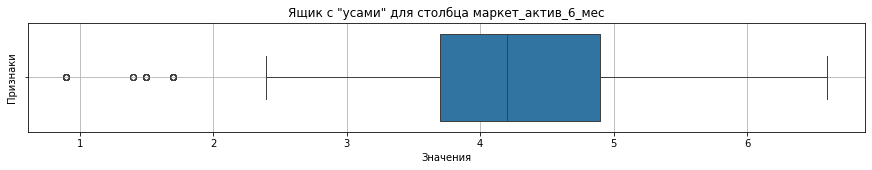

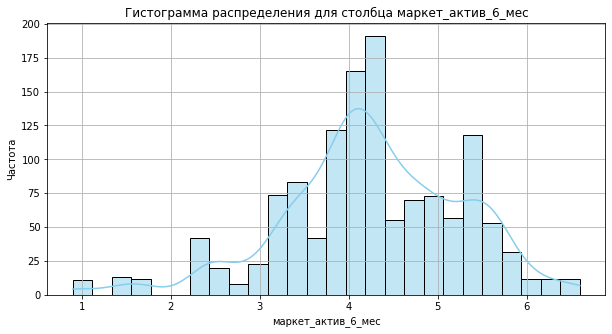


Статистика выбросов:

маркет_актив_6_мес: 36 выбросов

------------------------------------------------------------------------------------------------------------------------------------------------------

Описательная статистика:

count    1300.000000
mean        4.011538
std         0.696868
min         3.000000
25%         4.000000
50%         4.000000
75%         4.000000
max         5.000000
Name: маркет_актив_тек_мес, dtype: float64


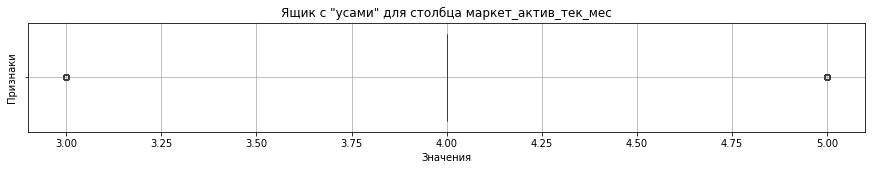

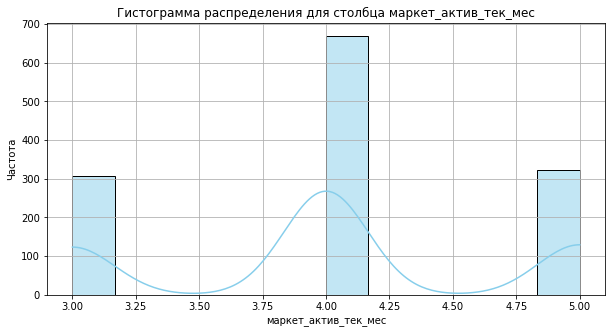


Статистика выбросов:

маркет_актив_тек_мес: 631 выбросов

------------------------------------------------------------------------------------------------------------------------------------------------------

Описательная статистика:

count    1300.000000
mean      601.898462
std       249.856289
min       110.000000
25%       405.500000
50%       606.000000
75%       806.000000
max      1079.000000
Name: длительность, dtype: float64


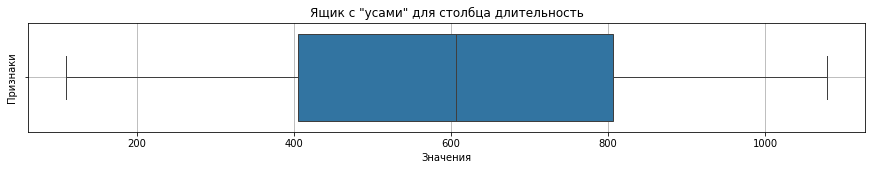

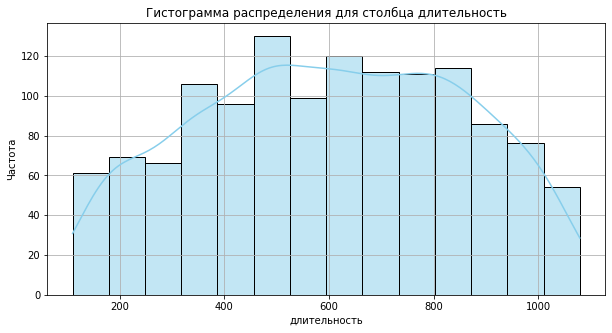


Статистика выбросов:

длительность: 0 выбросов

------------------------------------------------------------------------------------------------------------------------------------------------------

Описательная статистика:

count    1300.000000
mean        0.319808
std         0.249843
min         0.000000
25%         0.170000
50%         0.240000
75%         0.300000
max         0.990000
Name: акционные_покупки, dtype: float64


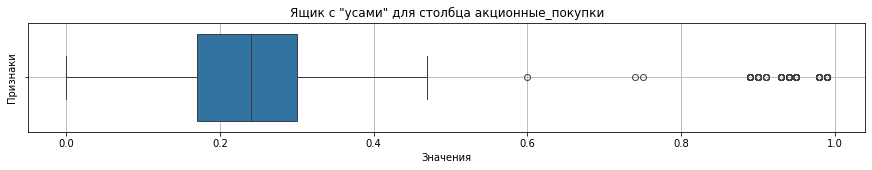

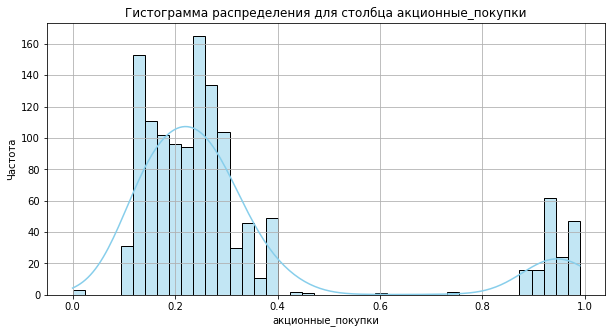


Статистика выбросов:

акционные_покупки: 168 выбросов

------------------------------------------------------------------------------------------------------------------------------------------------------

Описательная статистика:

count    1300.00000
mean        3.27000
std         1.35535
min         1.00000
25%         2.00000
50%         3.00000
75%         4.00000
max         6.00000
Name: средний_просмотр_категорий_за_визит, dtype: float64


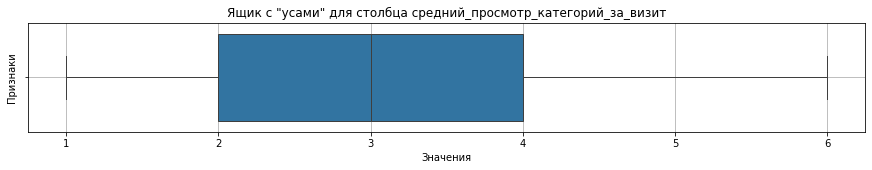

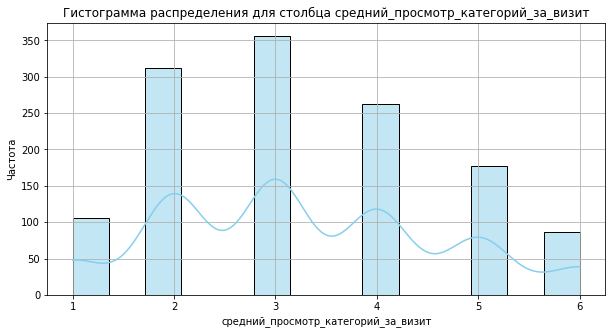


Статистика выбросов:

средний_просмотр_категорий_за_визит: 0 выбросов

------------------------------------------------------------------------------------------------------------------------------------------------------

Описательная статистика:

count    1300.000000
mean        2.840000
std         1.971451
min         0.000000
25%         1.000000
50%         3.000000
75%         4.000000
max        10.000000
Name: неоплаченные_продукты_штук_квартал, dtype: float64


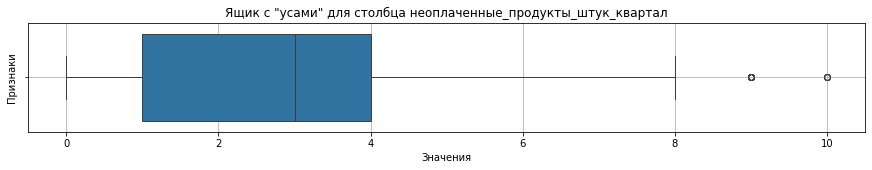

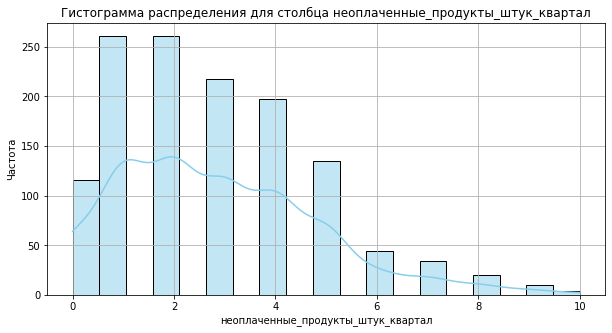


Статистика выбросов:

неоплаченные_продукты_штук_квартал: 14 выбросов

------------------------------------------------------------------------------------------------------------------------------------------------------

Описательная статистика:

count    1300.000000
mean        4.185385
std         1.955298
min         0.000000
25%         3.000000
50%         4.000000
75%         6.000000
max         9.000000
Name: ошибка_сервиса, dtype: float64


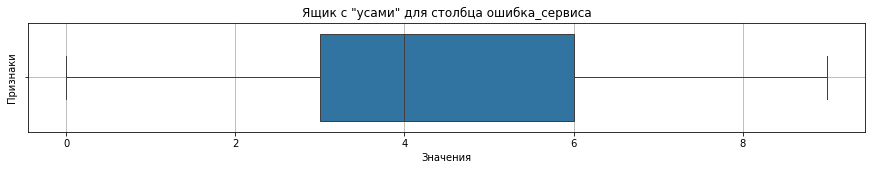

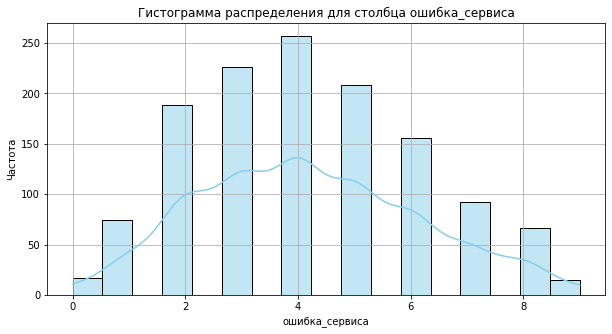


Статистика выбросов:

ошибка_сервиса: 0 выбросов

------------------------------------------------------------------------------------------------------------------------------------------------------

Описательная статистика:

count    1300.000000
mean        8.176923
std         3.978126
min         1.000000
25%         5.000000
50%         8.000000
75%        11.000000
max        20.000000
Name: страниц_за_визит, dtype: float64


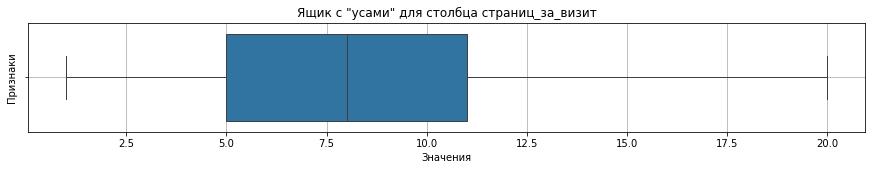

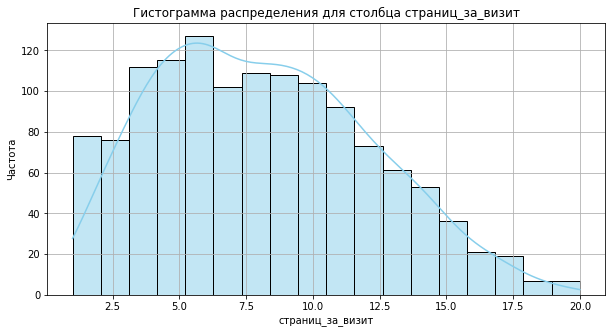


Статистика выбросов:

страниц_за_визит: 0 выбросов

------------------------------------------------------------------------------------------------------------------------------------------------------


In [34]:
numeric_visualization(market_file_df, num_cols_market_file_df)

Столбец **"маркет_актив_6_мес"**(показывает среднемесячное значение маркетинговых коммуникаций компании, которое приходилось на покупателя за последние 6 месяцев) на гистограмме распределения имеет форму нормального распредления с небольшим "хвостом" слева. Этот "хвост" на графике "ящик с усами" отображается как выбросы объемом 36 записей со значениями меньше 2. Посмотрим на эти строки:

In [35]:
market_file_df[market_file_df['маркет_актив_6_мес'] < 2].sort_values(by='маркет_актив_6_мес', ascending=True)

,номер_покупателя,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит
81,215429,Снизилась,премиум,нет,0.9,4,690,0.24,Домашний текстиль,2,5,7,4
204,215552,Снизилась,стандарт,да,0.9,4,624,0.89,Косметика и аксесуары,1,9,5,1
205,215553,Снизилась,стандарт,да,0.9,4,360,0.33,Домашний текстиль,2,3,3,5
164,215512,Снизилась,стандарт,да,0.9,3,839,0.40,Косметика и аксесуары,3,3,7,7
147,215495,Снизилась,стандарт,да,0.9,4,788,0.98,Техника для красоты и здоровья,3,3,3,3
253,215601,Снизилась,премиум,да,0.9,4,468,0.23,Техника для красоты и здоровья,1,6,4,4
269,215617,Снизилась,стандарт,да,0.9,4,728,0.90,Домашний текстиль,2,3,2,4
1287,216635,Прежний уровень,стандарт,да,0.9,3,932,0.35,Косметика и аксесуары,3,3,8,5
353,215701,Снизилась,стандарт,да,0.9,4,212,0.95,Домашний текстиль,2,5,4,2
357,215705,Снизилась,премиум,нет,0.9,4,657,0.99,Домашний текстиль,2,4,2,5


Какие-то четкие закономерности для данного набора записей трудно выделить, но однозначно можно сказать, что почти для всех этих пользователей уровень покупательской активности снизился, во всех остальных столбцах четких закономерностей не выявлено. 

В остальном данные имеют правдоподобный вид, поэтому для этого столбца всё оставляем как есть, пока что просто держим этот момент в уме.

Столбец **"маркет_актив_тек_мес"** (количество маркетинговых коммуникаций в текущем месяце) имеет всего 3 значения: 3, 4 и 5. В данном случае это количественный дискретный признак с преобладающим значением 4.

Столбец **"длительность"** (показывает, сколько дней прошло с момента регистрации покупателя на сайте) на гистограмме имеет форму нормального распределения, выбросы отсутствуют. Основная часть значений находится в диапазоне от 400 до 800 дней.

Столбец **"акционные_покупки"** (среднемесячная доля покупок по акции от общего числа покупок за последние 6 месяцев) на гистограмме имеет форму нормального распределения с отдельным "холмом" справа, который образует определнную группу покупателей. Основная часть пользователей имеет среднемесячную долю покупок по акции от общего числа покупок за последние 6 месяцев в диапазоне от 17% до 30%, а группа "холма" на гистограмме имеет среднемесячную долю покупок по акции от общего числа покупок за последние 6 месяцев в диапазоне от 88% до 99%. Эти значения маловероятно являются выбросами, скорее всего это значения описывающие определенное потребительское поведение.

Столбец **"средний_просмотр_категорий_за_визит"** (показывает, сколько в среднем категорий покупатель просмотрел за визит в течение последнего месяца) имеет форму нормального распредления при дискретных значениях от 1 до 6. Основаная масса пользователей имеет среднее количество просмотренных категорий за визит в диапазоне от 2 до 4.

Столбец **"неоплаченные_продукты_штук_квартал"** (общее число неоплаченных товаров в корзине за последние 3 месяца) имеет форму скошенного влево нормального распредления. Основаная масса пользователей имеет среднее количество неоплаченных товаров в корзине за последние 3 месяца в диапазоне от 0 до 5. На графике "ящик с усами" значения для этого столбца равные 9 и 10 являются выбросами, таких строк у нас 14 штук. Посомтрим на них:


In [36]:
market_file_df[market_file_df['неоплаченные_продукты_штук_квартал'] > 8]

,номер_покупателя,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит
72,215420,Снизилась,стандарт,да,3.5,5,449,0.35,Домашний текстиль,1,9,2,2
73,215421,Снизилась,премиум,нет,4.0,5,523,0.94,Техника для красоты и здоровья,1,10,7,5
117,215465,Снизилась,стандарт,да,3.5,5,449,0.28,Домашний текстиль,1,9,2,2
118,215466,Снизилась,премиум,нет,2.4,5,523,0.30,Техника для красоты и здоровья,1,10,1,4
176,215524,Снизилась,стандарт,да,3.0,3,474,0.23,Техника для красоты и здоровья,1,10,4,2
186,215534,Снизилась,премиум,нет,4.0,4,419,0.93,Товары для детей,1,9,3,3
204,215552,Снизилась,стандарт,да,0.9,4,624,0.89,Косметика и аксесуары,1,9,5,1
216,215564,Снизилась,стандарт,нет,3.9,3,618,0.24,Техника для красоты и здоровья,2,10,3,5
246,215594,Снизилась,стандарт,да,4.2,4,627,0.90,Товары для детей,6,9,5,8
251,215599,Снизилась,стандарт,да,3.4,4,716,0.28,Домашний текстиль,2,9,4,6


Явные закономерности для данных записей выделить трудно, но видно что у всех этих пользователей "покупательская_активность" снизилась.

Столбец **"ошибка_сервиса"** (число сбоев, которые коснулись покупателя во время посещения сайта) имеет форму нормального распределения. Основная масса значений находится в диапазоне от 3 до 6.

Столбец **"страниц_за_визит"** (среднее количество страниц, которые просмотрел покупатель за один визит на сайт за последние 3 месяца) имеет форму нормального распределения без "хвоста" слева и с небольшим "хвостом" справа. Основная масса значений находится в диапазоне от 1 до 11.

Теперь исследуем категориальные признаки.


Статистика уникальных значений:

Прежний уровень    802
Снизилась          498
Name: покупательская_активность, dtype: int64
Количество уникальных значений: 2
----------------------------------------


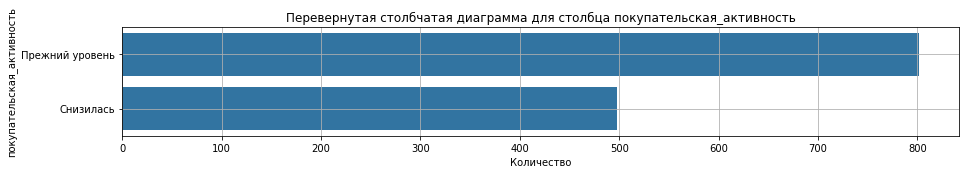

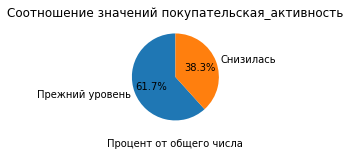

------------------------------------------------------------------------------------------------------------------------------------------------------

Статистика уникальных значений:

стандарт    924
премиум     376
Name: тип_сервиса, dtype: int64
Количество уникальных значений: 2
----------------------------------------


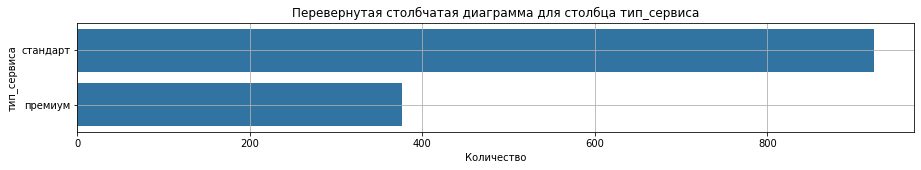

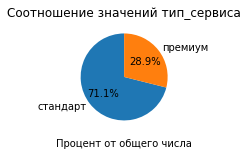

------------------------------------------------------------------------------------------------------------------------------------------------------

Статистика уникальных значений:

да     962
нет    338
Name: разрешить_сообщать, dtype: int64
Количество уникальных значений: 2
----------------------------------------


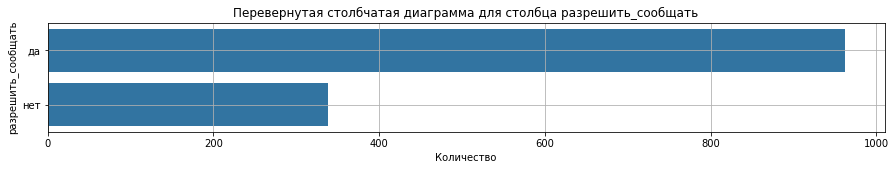

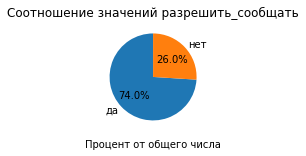

------------------------------------------------------------------------------------------------------------------------------------------------------

Статистика уникальных значений:

Товары для детей                        330
Домашний текстиль                       251
Косметика и аксесуары                   223
Техника для красоты и здоровья          184
Мелкая бытовая техника и электроника    174
Кухонная посуда                         138
Name: популярная_категория, dtype: int64
Количество уникальных значений: 6
----------------------------------------


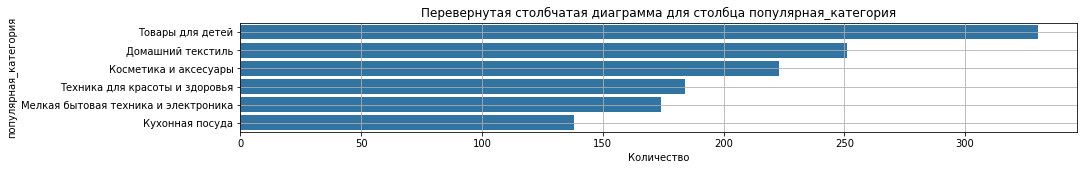

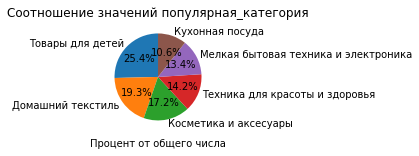

------------------------------------------------------------------------------------------------------------------------------------------------------


In [37]:
categorical_visualization(market_file_df, cat_cols_market_file_df)

Столбец **"покупательская_активность"** (рассчитанный класс покупательской активности (целевой признак)) соотношение классов "снизилась" и "прежний уровень" составляет примерно 39 % : 61 %. Это говорит нам о "легком" дисбалансе в данных. При построении моделей мы должны учитывать это и использовать техники борьбы с дисбалансом. Так же в данном  столбце содержится всего лишь два уникальных значения, что говорит о том, что перед нами задача бинарной классификации.

Столбец **"тип_сервиса"** (уровень сервиса) соотношение классов "премиум" и "стандарт" составляет примерно 29 % : 71 %.

Столбец **"разрешить_сообщать"** (информация о том, можно ли присылать покупателю дополнительные предложения о товаре) соотношение классов "да" и "нет" составляет примерно 74 % : 26 %.

Столбец **"популярная_категория"** (самая популярная категория товаров у покупателя за последние 6 месяцев) имеет 6 классов. Больше половины от общего числа записей формируют три основных класса "товары для детей", "домашний текстиль" и "косметика и аксессуары". Из этой информации можно сделать предположение, что основная часть покупателей является женской половиной. Этот факт может быть полезным при дополнительных исследованиях и составлении рекомендаций заказчику.

Первый датафрейм успешно исследован. Необходимые сведения получены. 

Переходим к исследованию следующего датафрейма - `market_money_df`.

In [38]:
market_money_df.sample(5)

,номер_покупателя,период,выручка
571,215538,препредыдущий_месяц,4641.0
3040,216361,предыдущий_месяц,4254.5
3343,216462,предыдущий_месяц,4344.0
2537,216193,предыдущий_месяц,5440.0
1020,215688,препредыдущий_месяц,4346.0


В данном датафрейме у нас содержится один категориальный признак **"период"** и один числовой **"выручка"**. Будем исследовать **"выручку"** для каждого отдельного периода. Поэтому сначала начнем с самогО **"периода"**.


Статистика уникальных значений:

предыдущий_месяц       1300
текущий_месяц          1300
препредыдущий_месяц    1300
Name: период, dtype: int64
Количество уникальных значений: 3
----------------------------------------


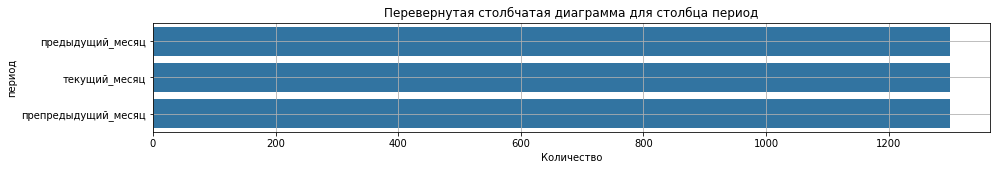

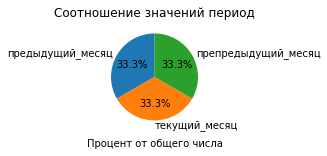

------------------------------------------------------------------------------------------------------------------------------------------------------


In [39]:
categorical_visualization(market_money_df, ['период'])

Для каждого периода у нас равное количество записей.

Перейдем к исследованию **"выручки"** по периодам.

препредыдущий_месяц


Описательная статистика:

count    1300.000000
mean     4825.206923
std       405.979663
min         0.000000
25%      4583.000000
50%      4809.000000
75%      5053.500000
max      5663.000000
Name: выручка, dtype: float64


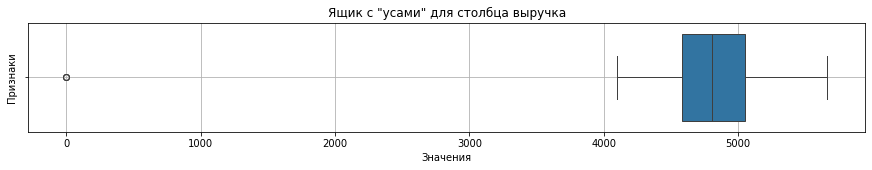

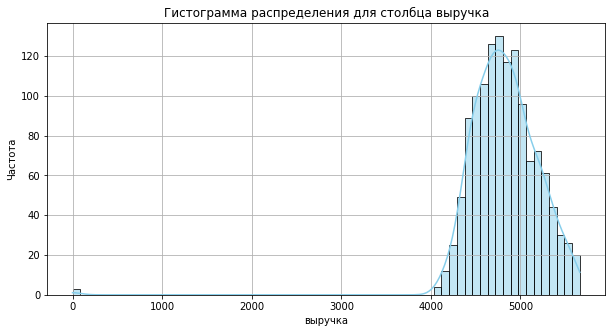


Статистика выбросов:

выручка: 3 выбросов

------------------------------------------------------------------------------------------------------------------------------------------------------
текущий_месяц


Описательная статистика:

count      1300.000000
mean       5314.960846
std        2939.708156
min        2758.700000
25%        4706.050000
50%        5179.950000
75%        5761.725000
max      106862.200000
Name: выручка, dtype: float64


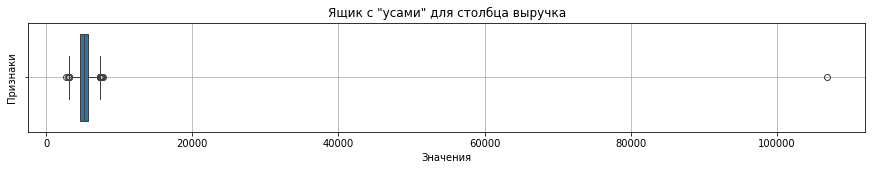

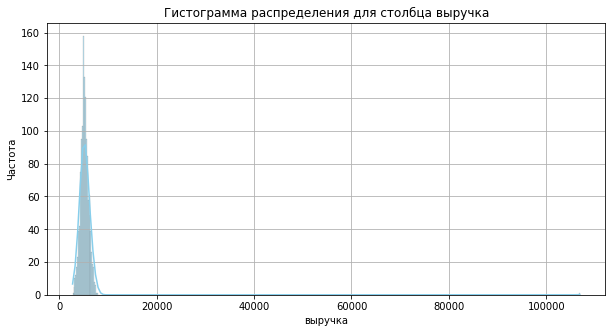


Статистика выбросов:

выручка: 16 выбросов

------------------------------------------------------------------------------------------------------------------------------------------------------
предыдущий_месяц


Описательная статистика:

count    1300.000000
mean     4936.920385
std       739.597997
min         0.000000
25%      4496.750000
50%      5005.000000
75%      5405.625000
max      6869.500000
Name: выручка, dtype: float64


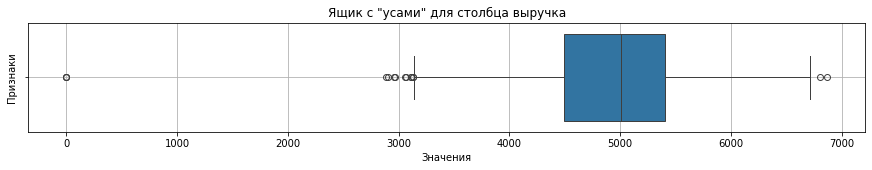

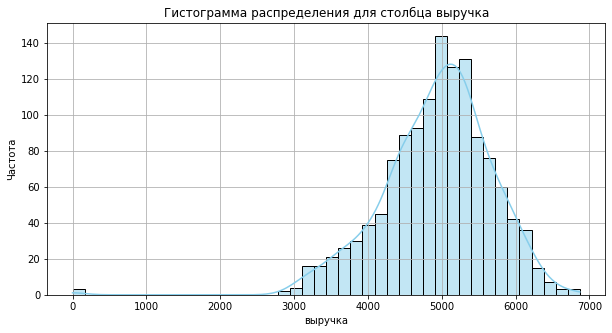


Статистика выбросов:

выручка: 15 выбросов

------------------------------------------------------------------------------------------------------------------------------------------------------


In [40]:
for period in market_money_df['период'].unique():
    print(period + '\n')
    numeric_visualization(market_money_df[market_money_df['период'] == period], ['выручка'])

Графики "сморщились"(для периода *"текущий месяц"*) из-за значения "чемпиона" со значением выручки 106862 (единицы измерения в описании проекта не указаны, обратных контактов не удалось найти, преподаватель сказал что попробует уточнить у команды авторов). Посмотрим отдельно на эту запись(и на этого пользователя) и на то как будут построены графики без этой записи.

In [41]:
market_money_df[market_money_df['выручка'] == 106862.2]

,номер_покупателя,период,выручка
98,215380,текущий_месяц,106862.2


In [42]:
market_file_df[market_file_df['номер_покупателя'] == 215380]

,номер_покупателя,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит
32,215380,Снизилась,премиум,нет,1.7,4,637,0.94,Техника для красоты и здоровья,3,2,4,7


Кроме того, что сумма выбивается из общей массы значений, каких-то других аномалий для данного пользвателя не видно. Судя по доле *"акционных_покупок"* и *"популярной_категории"* у этого пользователя, можно предположить, что это нейл-мастер или бьюти-мастер, который закупил товары для своего малого бизнеса. Так же это может быть связано с тенденцией заводить "общие" аккаунты для максимизации выгоды от скидочных программ/акций. В любом случае значение выручки сильно выбивается и учитывая наши предположения можно сказать, что это пользователь с нестандартным потребительским поведением. Что с ним делать решим чуть-чуть позже.

Посмотрим на график по **"выручке"** без этого пользователя.


Описательная статистика:

count    1299.000000
mean     5236.787452
std       835.474686
min      2758.700000
25%      4705.500000
50%      5179.600000
75%      5759.950000
max      7799.400000
Name: выручка, dtype: float64


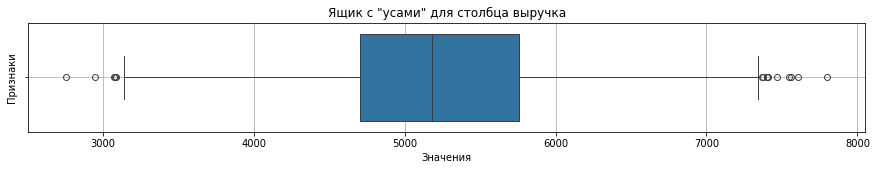

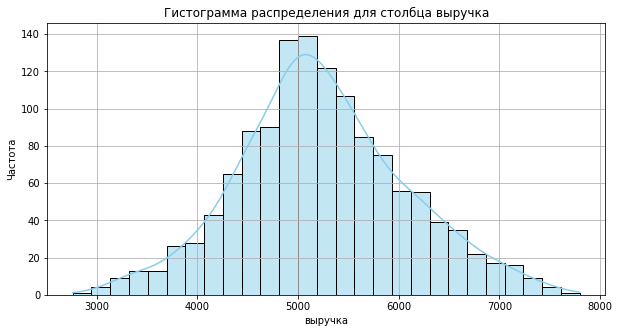


Статистика выбросов:

выручка: 15 выбросов

------------------------------------------------------------------------------------------------------------------------------------------------------


In [43]:
numeric_visualization(market_money_df[(market_money_df['номер_покупателя'] != 215380) & (market_money_df['период'] == 'текущий_месяц')], ['выручка'])

Теперь график **"выручки"** можно "читать". Он имеет форму нормально распредления с основной массой значений в диапазоне от 3000 до 7000. 

Особое внимание стоит уделить нулевым значениям. Посмотрим на эти строки в этом датафрейме и на соответствующие строки в датафрейме `market_file_df`.

In [44]:
market_money_df[market_money_df['выручка'] == 0]

,номер_покупателя,период,выручка
0,215348,препредыдущий_месяц,0.0
2,215348,предыдущий_месяц,0.0
28,215357,препредыдущий_месяц,0.0
29,215357,предыдущий_месяц,0.0
34,215359,предыдущий_месяц,0.0
35,215359,препредыдущий_месяц,0.0


In [45]:
market_file_df[market_file_df['номер_покупателя'].isin(market_money_df[market_money_df['выручка'] == 0]['номер_покупателя'])]

,номер_покупателя,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.0,Товары для детей,6,2,1,5
9,215357,Снизилась,стандарт,да,3.9,5,154,0.0,Техника для красоты и здоровья,3,3,9,5
11,215359,Снизилась,стандарт,да,4.6,5,110,0.0,Домашний текстиль,4,2,4,2


Опять же каких-то четких закономерностей у нас не получилось выявить. Скорее всего это просто пользователи, которые зарегистрировались, но не совершили ни одной покупки.

Перейдем к анализу датафрейма `market_time_df`.

In [46]:
market_time_df.sample(5)

,номер_покупателя,период,минут
1020,215858,текущий_месяц,6
555,215625,текущий_месяц,6
1890,216293,текущий_месяц,10
1892,216294,текущий_месяц,19
683,215689,предыдущий_месяц,11


Похожая структура у нас была и в предыдущем датафрейме. Начнем с исследования "периода". И далее для каждого периода построим гистограммы для столбца "минут".


Статистика уникальных значений:

предыдущий_месяц    1300
текущий_месяц       1300
Name: период, dtype: int64
Количество уникальных значений: 2
----------------------------------------


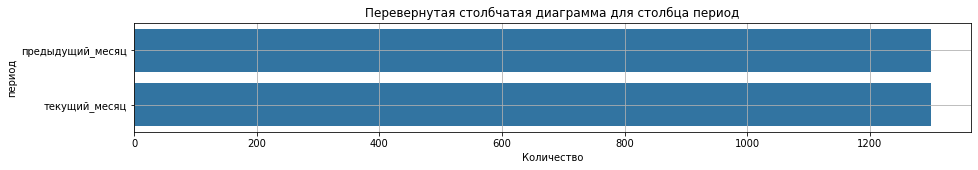

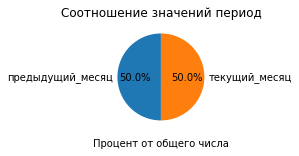

------------------------------------------------------------------------------------------------------------------------------------------------------


In [47]:
categorical_visualization(market_time_df, ['период'])

У нас поровну представлены записи для двух периодов. Теперь построим гистограммы для каждого периода по минутам проведенным пользователем на сайте.

текущий_месяц


Описательная статистика:

count    1300.000000
mean       13.204615
std         4.220589
min         4.000000
25%        10.000000
50%        13.000000
75%        16.000000
max        23.000000
Name: минут, dtype: float64


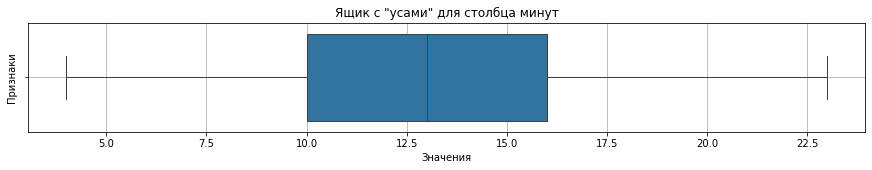

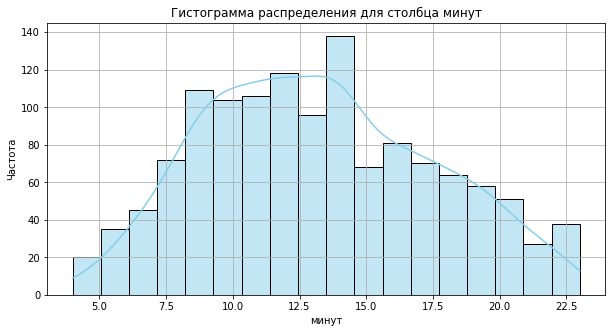


Статистика выбросов:

минут: 0 выбросов

------------------------------------------------------------------------------------------------------------------------------------------------------
предыдущий_месяц


Описательная статистика:

count    1300.000000
mean       13.467692
std         3.932029
min         5.000000
25%        11.000000
50%        13.000000
75%        17.000000
max        23.000000
Name: минут, dtype: float64


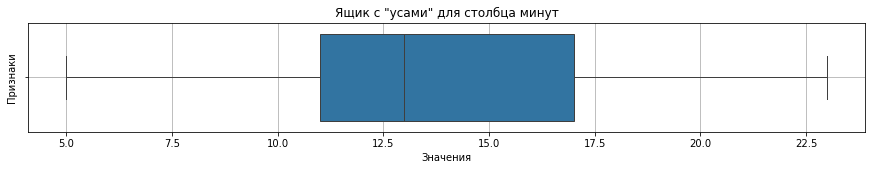

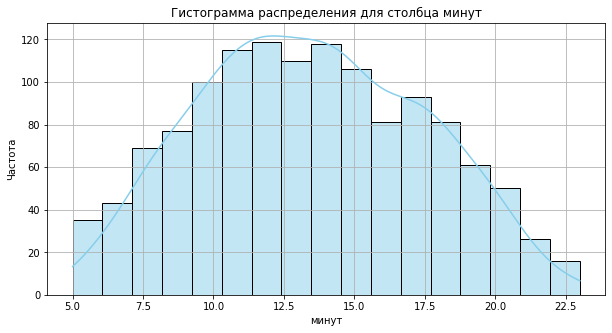


Статистика выбросов:

минут: 0 выбросов

------------------------------------------------------------------------------------------------------------------------------------------------------


In [48]:
for period in market_time_df['период'].unique():
    print(period + '\n')
    numeric_visualization(market_time_df[market_time_df['период'] == period], ['минут'])

Данные распредлены нормально, выбросы отсутствуют. Медианное значение для обоих периодов составляет 13 минут.

У нас остался последний датафрейм `money_df`. Исследуем его по такому же алгоритму, как и предыдущие датафреймы.

In [49]:
money_df.sample(5)

,номер_покупателя,прибыль
297,215645,2.49
36,215384,4.78
1181,216529,3.87
911,216259,4.30
283,215631,3.47



Описательная статистика:

count    1300.000000
mean        3.996631
std         1.013722
min         0.860000
25%         3.300000
50%         4.045000
75%         4.670000
max         7.430000
Name: прибыль, dtype: float64


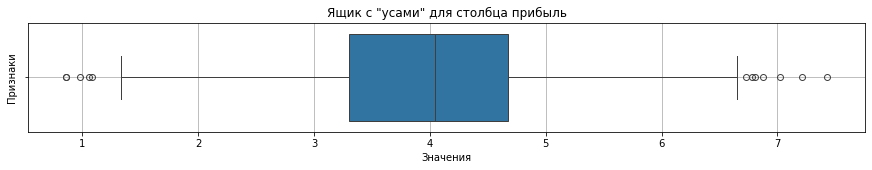

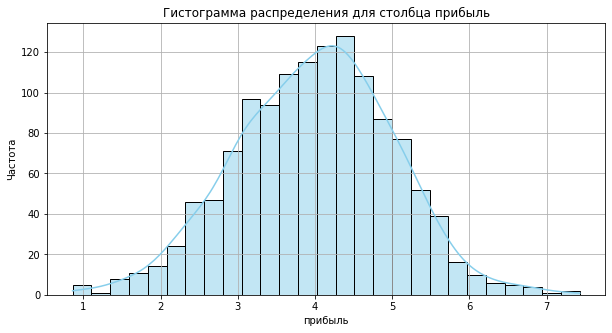


Статистика выбросов:

прибыль: 12 выбросов

------------------------------------------------------------------------------------------------------------------------------------------------------


In [50]:
numeric_visualization(money_df, ['прибыль'])

График имеет форму нормального распределения, выбросов нет, основная масса значений находится в диапазоне от 2 до 6. В каких единицах измеряется данный признак в описании проекта не указано.


### В целом исследовательский анализ проведен успешно, подсветим основные выводы.

`market_file_df`:

1. Значения числовых признаков в основном имеют нормальное распределение, какие-то значения лежат вне диапазона от первого до третьего квартиля, при этом это вполне реальные и допустимые значения. 

2. Так же в столбце **"акционные_покупки"** есть значения, которые формируют "холм" на гистограмме и образуют определнный шаблон потребления. 

3. В столбце **"покупательская_активность"** (целевой признак) присутствует дисбаланс классов.

`market_money_df`:

1. Был найден выброс в столбце **"выручка"** со значением около 106862. На данный момент сформировались лишь предположения по поводу этого выброса и решение по его обработке не принято окончательно.

2. Также мы выявили пользователей, которые не совершали никаких покупок за весь период представленный в данных. Поэтому таких пользователей мы не будем включать ни в какие выборки на последующих этапах проекта.

В датафреймах `market_time_df` и `money_df` каких-то особых закономерностей не выявлено. Значения в категориальных столбцах распределены равномерно. А значения в числовых столбцах имеют нормальное распределение.



Посмотрим на гистрограммы распределения числовых признаков в разрезе целевого признака.

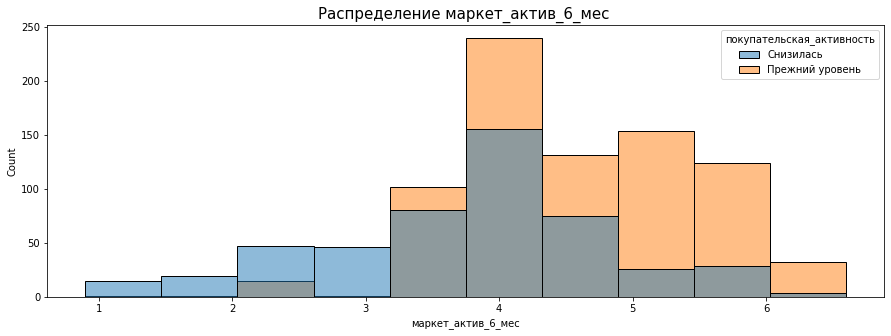

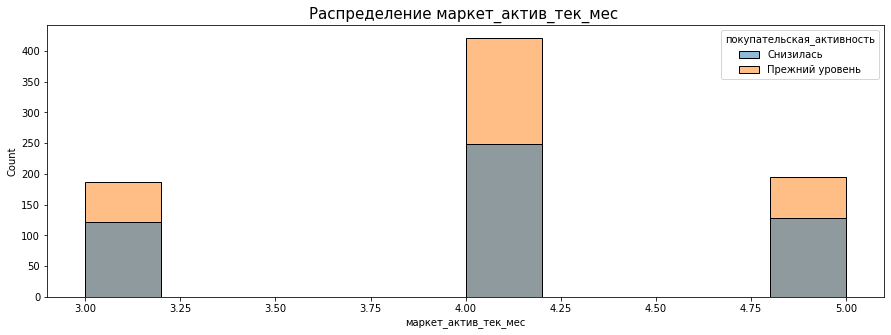

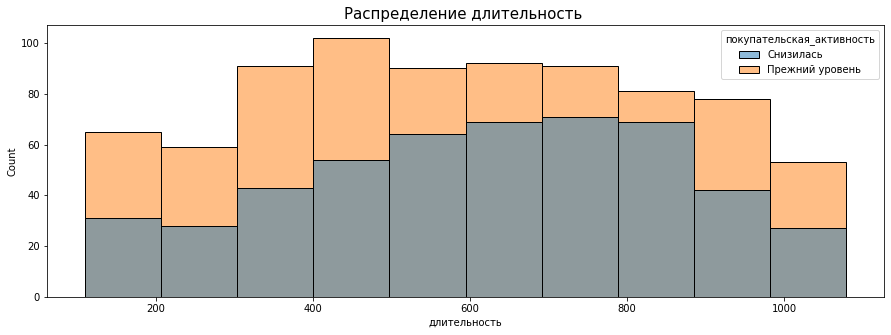

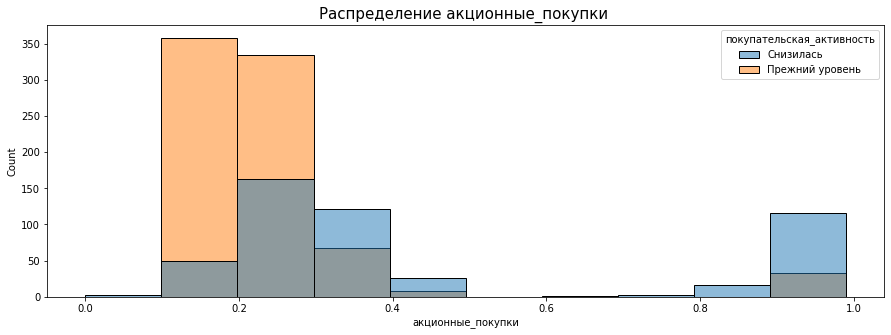

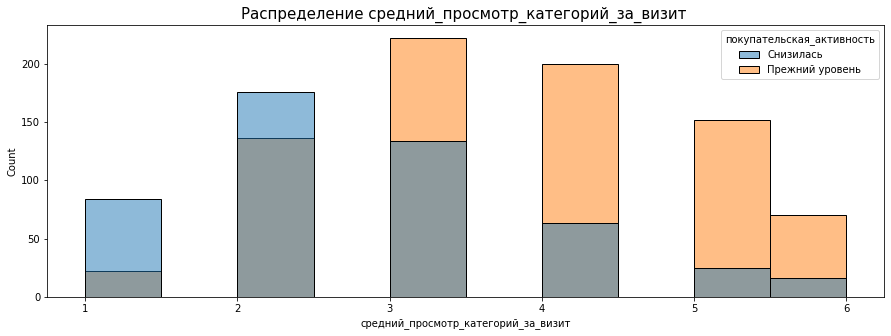

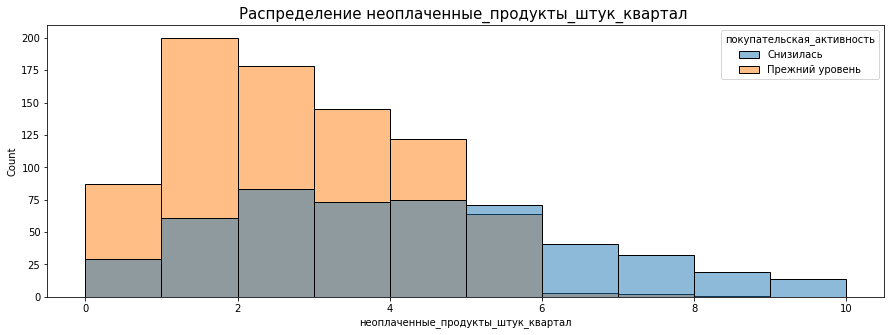

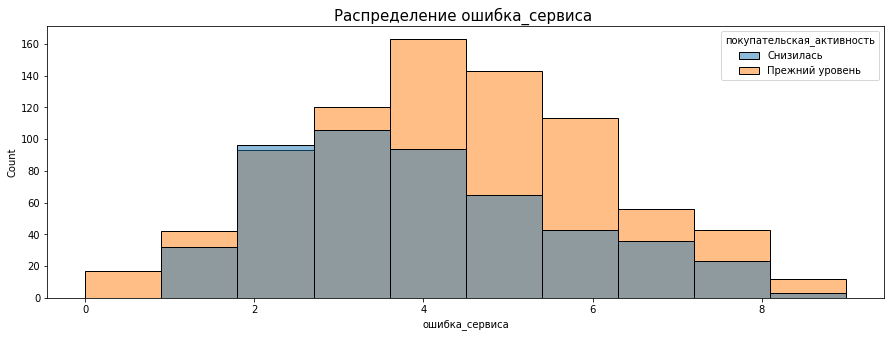

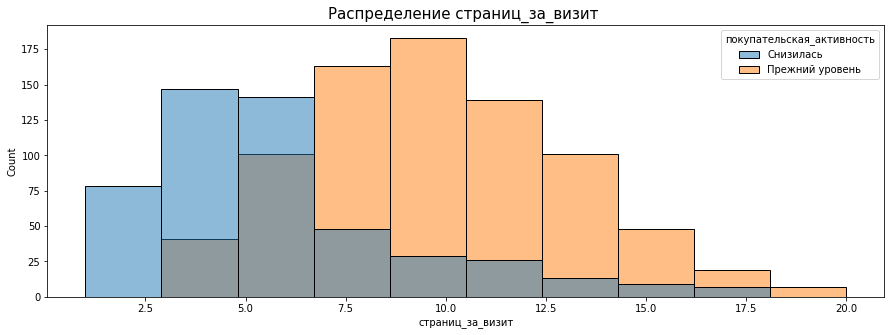

In [51]:
for num_col in num_cols_market_file_df:
    plt.figure(figsize=(15, 5))
    sns.histplot(data=market_file_df, x=num_col, bins=10, hue="покупательская_активность") 

    plt.title(f"Распределение {num_col} ", fontsize=15)  
    plt.show() 

Из гистограмм для числовых признаков в разрезе таргета видны следующие особенности:
- **"маркет_актив_6_мес"** показывает, что для класса активности "снизилась" основная масса значений лежит от 2 до 5, при том что для класса активности "прежний уровень" основная масса значений лежит в диапазоне от 3 до 6.
- **"акционные_покупки"** начиная от доли акционных покупок от общего числа товаров равной 0.3 начинает увеличиваться количетство пользователей с классом аквтивности "снизилась". Для пользователей с прежней активность в основной массе характерны значения от 0.1 до 0.3.
- **"средний_просмотр_категорий_за_визит"** для класса активности "снизилась" - основная масса значений лежит в диапазоне от 1 до 4, а для пользователей с прежней активность - от 2 до 5.
- **"неоплаченные_продукты_штук_квартал"** для клиентов с прежним уровнем активности основная масса значений лежит в диапазоне от 0 до 6, а для класса со снижающимся уровнем активности от 0 до 8. При том что от значения 6 неоплаченных продуктов в корзине и выше на графике находятся почти только пользователи со снижающимся уровнем активности.
- **"ошибка_сервиса"** для клиентов со снижающейся покупателськой активностью основной диапазон значений этого показателя имеет значения от 2 до 4, а для пользователей с прежним уровнем активности от 2 до 6. Сам по себе этот признак вряд ли связан линейно с целевым показателем, скорее всего он косвенно может сигнализировать дополнительно о проводимом времени на сайте(в приложении) онлайн-магазина.
- **"страниц_за_визит"** основная масса зачений для двух классов активности внушительно отличается: для пользователей со снижением активности от 2 до 6 страниц, а для второго класса от 5 до 14 страниц.

Теперь построим столбчатые диаграммы для категориальных признаков в разрезе целевого.

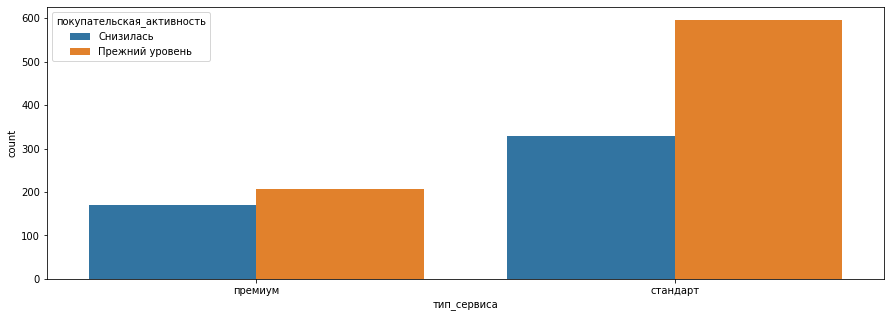

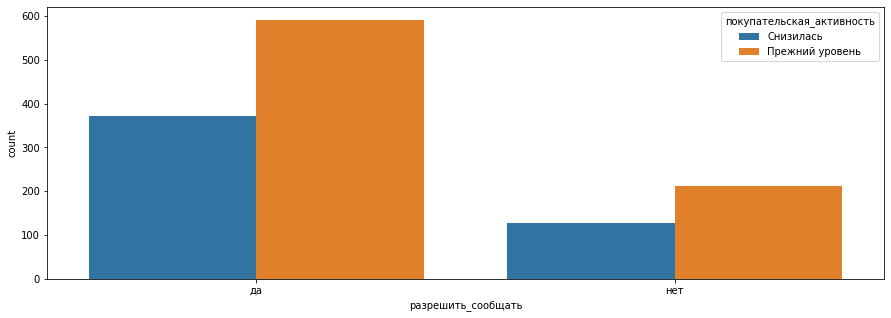

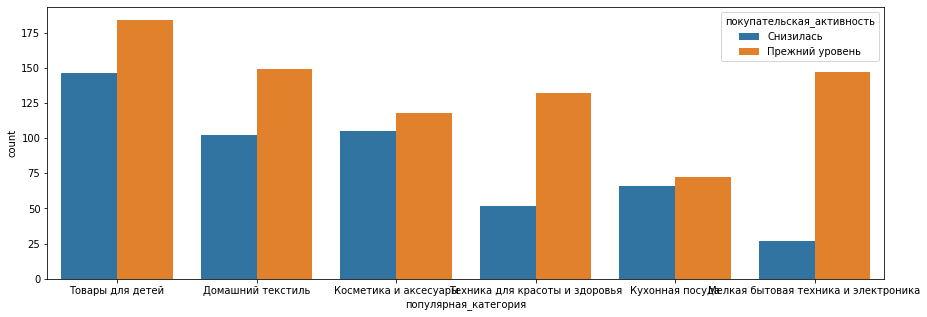

In [52]:
for col in ['тип_сервиса', 'разрешить_сообщать', 'популярная_категория']:
    plt.figure(figsize=(15, 5))
    sns.countplot(
        market_file_df, 
        x=col,
        hue="покупательская_активность", 
        legend=True
    )
    plt.show();

Из графиков можно выделить следующие особенности:

- наличие "премиум" подписки скорее всего не влияет на активность пользователя. Так как среди пользователей с "премиум" подпиской почти одинаковое количество пользователей, принадлежащих к обоим классам активности.
- среди пользователей, которые разрешили отправлять им дополнительную информацию достаточно большое количество с классом активности "снизилась". Этот факт можно использовать при разработке рекоммендаций по повышению покупательской активности.
- в популярных категориях "мелкая бытовая техника и электроника" и "техника для красоты и здоровья" значительно бОльшая доля от общего количества пользователей приходится на пользователей с прежней покупательской активностью.

**Промежуточный вывод** с портретом покупателя со снижающейся покупательской активностью. 

Из всех графиков и отмеченных на них особенностях, можно сказать следующее:

С пользователем у которого снижается покупателськая активность проводят меньше маркетинговых взаимодействий. Доля акционных покупок от общего числа товаров выше, чем у пользователя с прежним уровнем активности. Такой пользователь просматривает в среднем меньше категорий товаров за визит. У такого пользователя больше неоплаченных товаров в "корзине". Такой пользователь в среднем намного меньше просматривает страниц за визит, чем пользователь с прежней активностью. Скорее всего у такого пользователя разрешены уведомления с дополнительной информацией.

#### Объединим датафреймы `market_file_df`, `market_money_df`, `market_time_df`

In [53]:
print(market_file_df.shape)
print(market_money_df.shape)
print(market_time_df.shape)


(1300, 13)
(3900, 3)
(2600, 3)


In [54]:
# подготовка "market_money_df" для корректного объединения с "market_file_df"
market_money_df_to_merge = market_money_df.pivot_table(index='номер_покупателя', columns='период', values='выручка')
market_money_df_to_merge.columns = ['предыдущий_месяц_выручка', 'препредыдущий_месяц_выручка', 'текущий_месяц_выручка']

# объединение "market_file_df" и "market_money_df_to_merge"
data = market_file_df.join(market_money_df_to_merge, on='номер_покупателя')

# проверка результата объединения
print(data.shape)
data.sample(5)

(1300, 16)


,номер_покупателя,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,предыдущий_месяц_выручка,препредыдущий_месяц_выручка,текущий_месяц_выручка
1248,216596,Прежний уровень,стандарт,да,4.1,4,719,0.29,Домашний текстиль,6,4,5,10,4927.0,4882.0,5018.0
162,215510,Снизилась,стандарт,да,3.8,4,324,0.22,Техника для красоты и здоровья,2,7,2,2,4244.0,4814.0,4242.7
292,215640,Снизилась,стандарт,да,2.4,4,251,0.32,Техника для красоты и здоровья,2,7,1,5,4213.0,4310.0,4291.0
904,216252,Прежний уровень,премиум,да,4.3,3,1036,0.17,Товары для детей,4,2,2,4,3962.0,4536.0,4589.9
427,215775,Прежний уровень,стандарт,нет,5.0,4,157,0.15,Мелкая бытовая техника и электроника,5,0,5,13,4028.0,4934.0,3372.8


Объединение первых датафреймов прошло успешно, полученая таблица имеет корректную размерность

In [55]:
market_time_df

,номер_покупателя,период,минут
0,215348,текущий_месяц,14
1,215348,предыдущий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдущий_месяц,12
4,215350,текущий_месяц,13
...,...,...,...
2595,216645,текущий_месяц,18
2596,216646,предыдущий_месяц,18
2597,216646,текущий_месяц,7
2598,216647,текущий_месяц,10


In [56]:
# подготовка "market_time_df" для корректного объединения с "data"
market_time_df_to_merge = market_time_df.pivot_table(index='номер_покупателя', columns='период', values='минут')
market_time_df_to_merge.columns = ['предыдущий_месяц_минут', 'текущий_месяц_минут']

# объединение "data" и "market_time_df_to_merge"
data = data.join(market_time_df_to_merge, on='номер_покупателя')

# проверка результата объединения
print(data.shape)
data.sample(5)

(1300, 18)


,номер_покупателя,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,предыдущий_месяц_выручка,препредыдущий_месяц_выручка,текущий_месяц_выручка,предыдущий_месяц_минут,текущий_месяц_минут
864,216212,Прежний уровень,стандарт,нет,4.4,3,206,0.29,Товары для детей,4,4,6,12,4381.0,4831.0,4901.0,12,17
930,216278,Прежний уровень,стандарт,нет,5.7,4,391,0.16,Товары для детей,5,2,7,12,3898.0,5117.0,5084.9,19,16
130,215478,Снизилась,стандарт,да,4.1,4,753,0.24,Товары для детей,2,8,2,2,2960.0,4682.0,3078.3,10,14
702,216050,Прежний уровень,стандарт,нет,5.1,3,613,0.27,Домашний текстиль,4,1,3,12,5556.5,5573.0,5672.2,14,16
1292,216640,Прежний уровень,стандарт,нет,5.7,4,416,0.95,Кухонная посуда,2,3,5,13,4212.5,4679.0,3938.2,23,17


Все три датафрейма успешно объединены.

Теперь удалим пользователей с покупательской активностью менее трёх месяцев и строку с аномально большим значением выручки.

In [57]:
data = data.drop(data.query('предыдущий_месяц_выручка == 0 or препредыдущий_месяц_выручка == 0 or текущий_месяц_выручка == 0').index)
data = data.drop(data.query('номер_покупателя == 215380').index)
data.shape

(1296, 18)

## Корреляционный анализ

Построим матрицу корреляции для всех признаков набора `data`. Выделим также список с непрерывными признаками.

In [58]:
interval_cols = [
    'маркет_актив_6_мес', 
    'маркет_актив_тек_мес', 
    'длительность', 
    'акционные_покупки', 
    'средний_просмотр_категорий_за_визит',
    'неоплаченные_продукты_штук_квартал',
    'ошибка_сервиса',
    'страниц_за_визит',
    'предыдущий_месяц_выручка',
    'препредыдущий_месяц_выручка',
    'текущий_месяц_выручка',
    'предыдущий_месяц_минут',
    'текущий_месяц_минут'
    ]

In [59]:
phik_overview = data.drop('номер_покупателя', axis=1).phik_matrix(interval_cols=interval_cols)

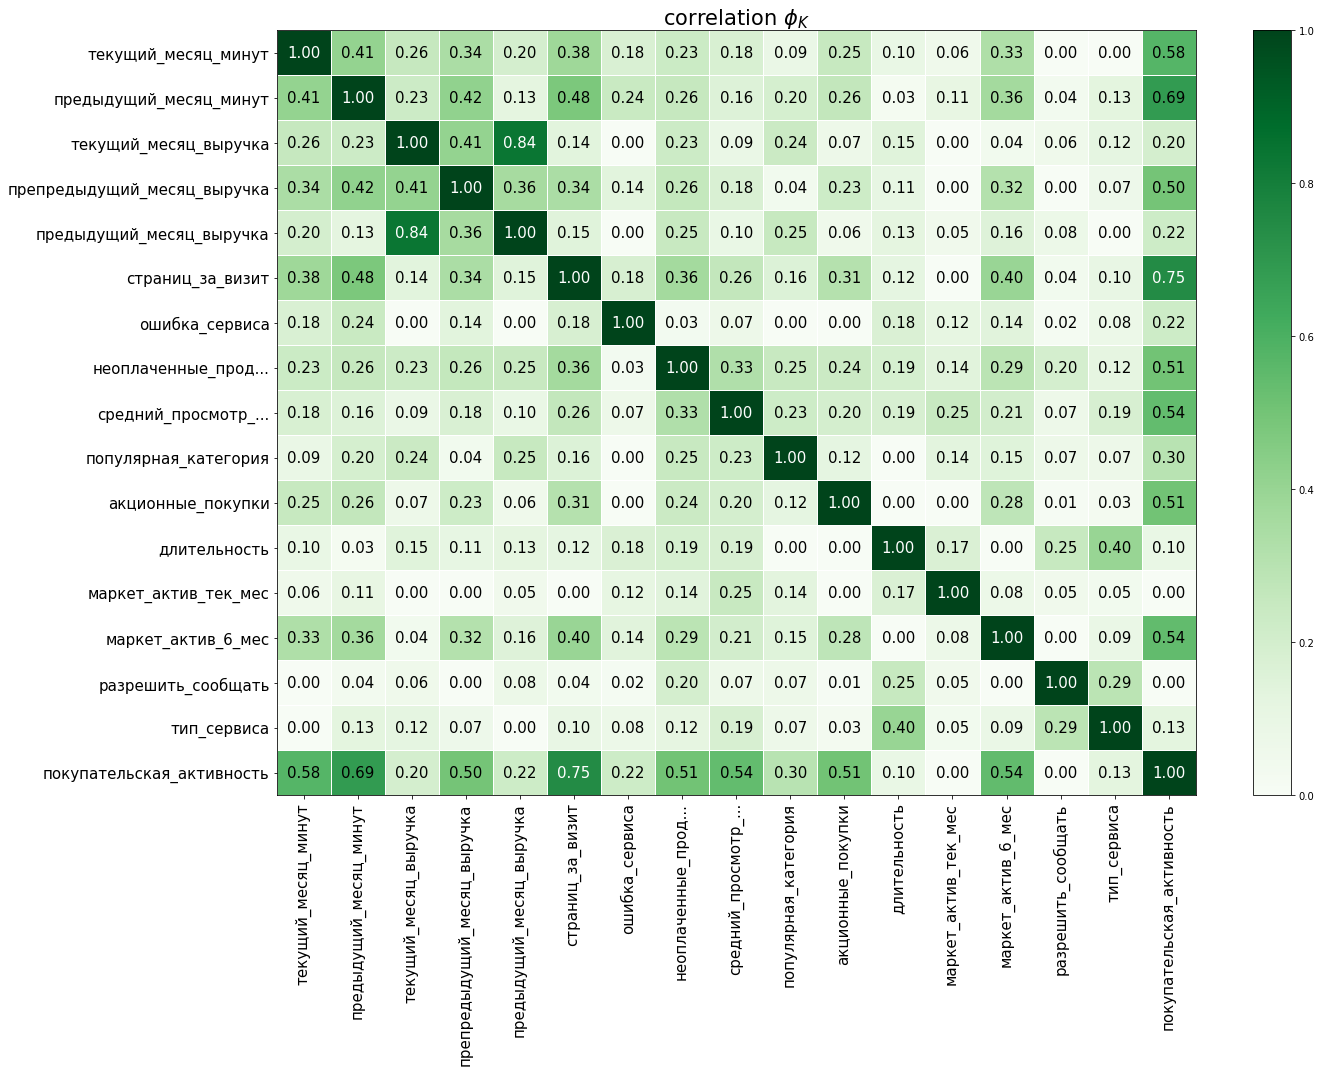

In [60]:
plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1, color_map='Greens',
    title=r'correlation $\phi_K$',
    fontsize_factor=1.5,
    top=30,
    figsize=(20, 15)
) 

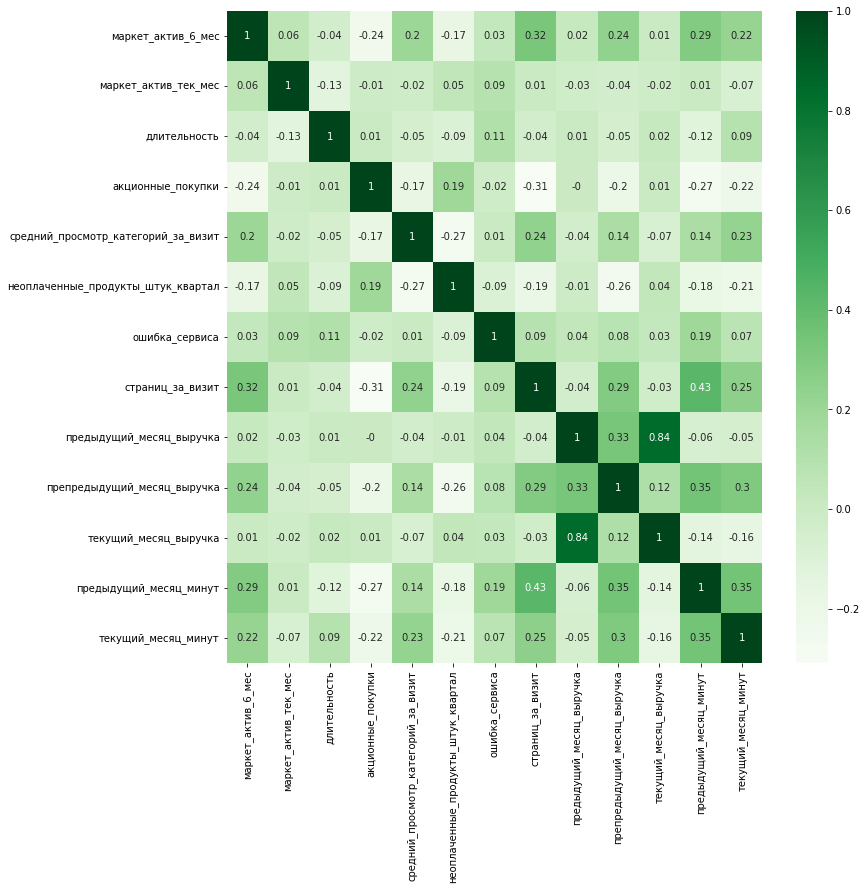

In [61]:
num_cols_data = data.select_dtypes(include=['int64', 'float64']).columns
num_cols_data = num_cols_data.drop('номер_покупателя')

matrix = data[num_cols_data].corr()

plt.figure(figsize=(12, 12))
sns.heatmap(matrix.round(2), cmap="Greens", annot=True);

Мы построили тепловую карту *phi_k* корреляции для всех признаков и матрицу корреляции *Пирсона* для числовых признаков.

Тепловая карта с корреляцией Пирсона в нашем случае показывает что линейная связь между числовыми признаками датасета почти отсутствует(либо умеренная), макимальное значение корреляции не более 0.44 и то всего лишь для нескольких признаков.

Тепловая карта *phi_k* корреляции имеет бОльшие значения корреляции, чем тепловая карта с корреляцией Пирсона. С целевым признаком **покупательская_активность** наиболее заметно связаны следующие входные признаки:
- **текущий_месяц_минут**(значение времени, проведённого на сайте, в минутах) со значением корреляции - 0.58
- **предыдущий_месяц_минут**(значение времени, проведённого на сайте, в минутах) со значением корреляции - 0.68
- **страниц_за_визит**(среднее количество страниц, которые просмотрел покупатель за один визит на сайт за последние 3 месяца) со значением корреляции - 0.75
- **средний_просмотр_категорий_за_визит**(показывает, сколько в среднем категорий покупатель просмотрел за визит в течение последнего месяца) со значением корреляции - 0.54
- **маркет_актив_6_мес**(среднемесячное значение маркетинговых коммуникаций компании, которое приходилось на покупателя за последние 6 месяцев) со значением корреляции - 0.55

Остальные признаки имеют значение корреляции с целевым признаком 0.5 и ниже.

Также на тепловой карте *phi_k* корреляции видны связи между входными признаками:
- **препредыдущий_месяц_выручка**(сумма выручки за период) имеет связь с **предыдущий_месяц_выручка**(сумма выручки за период) со значением корреляции 0.73 и с **акционные_покупки**(среднемесячная доля покупок по акции от общего числа покупок за последние 6 месяцев) со значением корреляции 0.75
- **предыдущий_месяц_выручка**(сумма выручки за период) имеет связь с **акционные_покупки**(среднемесячная доля покупок по акции от общего числа покупок за последние 6 месяцев) со значением корреляции 0.64

По результатам корреляционного анализа можно сказать, что в нашем наборе данных отсутвует мультиколлинеарность, так как связь между входными признаками присутствует, но не в такой степени, чтобы назвать их мультиколлинеарными.

## Создание пайпланов

Для начала разделим все наши признаки по группам в соответствии с тем, какими инструментами мы будем их готовить к обучению.
Для удобства выведем еще раз информацию о датафрейме и несколько строк.

In [62]:
data.info()
data.sample(5)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1296 entries, 1 to 1299
Data columns (total 18 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   номер_покупателя                     1296 non-null   int64  
 1   покупательская_активность            1296 non-null   object 
 2   тип_сервиса                          1296 non-null   object 
 3   разрешить_сообщать                   1296 non-null   object 
 4   маркет_актив_6_мес                   1296 non-null   float64
 5   маркет_актив_тек_мес                 1296 non-null   int64  
 6   длительность                         1296 non-null   int64  
 7   акционные_покупки                    1296 non-null   float64
 8   популярная_категория                 1296 non-null   object 
 9   средний_просмотр_категорий_за_визит  1296 non-null   int64  
 10  неоплаченные_продукты_штук_квартал   1296 non-null   int64  
 11  ошибка_сервиса                

,номер_покупателя,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,предыдущий_месяц_выручка,препредыдущий_месяц_выручка,текущий_месяц_выручка,предыдущий_месяц_минут,текущий_месяц_минут
1235,216583,Прежний уровень,премиум,да,3.3,3,280,0.30,Товары для детей,3,4,8,13,4443.0,4421.0,4553.5,17,14
311,215659,Снизилась,стандарт,нет,1.4,3,822,0.36,Товары для детей,2,5,7,6,5792.0,4709.0,6886.6,7,10
824,216172,Прежний уровень,премиум,да,5.5,4,633,0.18,Товары для детей,3,4,6,12,4381.0,4981.0,5031.0,16,16
1269,216617,Прежний уровень,премиум,нет,4.9,3,815,0.30,Косметика и аксесуары,2,3,5,7,4315.0,5062.0,3797.6,19,22
195,215543,Снизилась,премиум,нет,1.5,5,335,0.21,Товары для детей,2,0,5,3,4697.5,4684.0,4821.0,5,4


- **"номер_покупателя"** мы исключим из признаков для модели, так как он является идентификатором и не несет в себе информацию, которая может быть полезна для прогнозирования
- **"покупательская_активность"** это наш целевой признак, к нему мы будем применять кодировщик *"LabelEncoder"*
- **"тип_сервиса"**, **"разрешить_сообщать"**, **"популярная_категория"** являются категориальными признаками, которые мы будем кодировать с помощью кодировщика *"OneHotEncoder"*
- все остальные признаки у нас числовые, поэтому мы будем пробовать использовать разные кодировщики *"StandardScaler"* и *"MinMaxScaler"*

Сформируем списки наших признаков в коде.

In [63]:
target_for_label_encoder = ["покупательская_активность"]

features_for_one_hot_encoder = [
    "тип_сервиса", 
    "разрешить_сообщать", 
    "популярная_категория"
    ]

features_for_num_scalers = [
    "маркет_актив_6_мес", 
    "маркет_актив_тек_мес", 
    "длительность", 
    "акционные_покупки",
    "средний_просмотр_категорий_за_визит",
    "неоплаченные_продукты_штук_квартал",
    "ошибка_сервиса",
    "страниц_за_визит",
    "предыдущий_месяц_выручка",
    "препредыдущий_месяц_выручка",
    "текущий_месяц_выручка",
    "предыдущий_месяц_минут",
    "текущий_месяц_минут"
    ]



В наших данных нету пропусков, так как мы провели предобработку данных, поэтому в пайплайнах мы не будем использовать "импьютеры".

Создадим промежуточные пайплайны для подготовки разных признаков.

In [64]:
# OHE
ohe_pipe = Pipeline(
    [
        (
            'ohe_non_binary', 
            OneHotEncoder(drop='first', sparse=False)
        ),
        (
            'ohe_binary', 
            OneHotEncoder(drop='if_binary', sparse=False)
        )
    ]
)

In [65]:
data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, features_for_one_hot_encoder),
        ('num', StandardScaler(), features_for_num_scalers)
    ], 
    remainder='passthrough'
) 

In [66]:
# итоговый пайплайн: подготовка данных и модель
pipe_final = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('selector', SelectKBest(f_classif)),
        ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
    ]
) 
pipe_final

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('ohe_non_binary',
                                                                   OneHotEncoder(drop='first',
                                                                                 sparse=False)),
                                                                  ('ohe_binary',
                                                                   OneHotEncoder(drop='if_binary',
                                                                                 sparse=False))]),
                                                  ['тип_сервиса',
                                                   'разрешить_сообщать',
                                                   'популярная_категория']),
                                                 ('num', StandardScaler(),
                                                  ['маркет_актив_6_мес',
                                                   'маркет_ак...
                                                   'длительность',
                                                   'акционные_покупки',
                                                   'средний_просмотр_категорий_за_визит',
                                                   'неоплаченные_продукты_штук_квартал',
                                                   'ошибка_сервиса',
                                                   'страниц_за_визит',
                                                   'предыдущий_месяц_выручка',
                                                   'препредыдущий_месяц_выручка',
                                                   'текущий_месяц_выручка',
                                                   'предыдущий_месяц_минут',
                                                   'текущий_месяц_минут'])])),
                ('selector', SelectKBest()),
                ('models', DecisionTreeClassifier(random_state=42))])

In [67]:
X_train, X_test, y_train, y_test = train_test_split(
    data.drop(
        [
            'номер_покупателя',
            'покупательская_активность'
        ], 
				axis=1
    ),
    data['покупательская_активность'],
    test_size = TEST_SIZE, 
    random_state = RANDOM_STATE,
    stratify = data['покупательская_активность']
)

Перед применением пайплайна закодируем целевой признак с помощью LabelEncoder вручную.

In [68]:
le_encoder = LabelEncoder()
y_train_le = le_encoder.fit_transform(y_train)
y_test_le = le_encoder.transform(y_test)

In [ ]:
# параметры для GridSearchCV    
param_distributions = [
    # словарь для модели KNeighborsClassifier() 
    {
        # название модели
        'models': [KNeighborsClassifier()],
        # указываем гиперпараметр модели n_neighbors
        'models__n_neighbors': range(1, 100),
        # указываем гиперпараметр модели leaf_size
        'models__leaf_size': range(1, 50),
        # указываем гиперпараметр модели algorithm
        'models__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
        # указываем список методов масштабирования
        'preprocessor__num': [StandardScaler(), MinMaxScaler()],
        # указываем количество признаков
        'selector__k':list(range(6,15))   
    },
    # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        # указываем гиперпараметр модели max_depth
        'models__max_depth': range(2, 11),
        # указываем гиперпараметр модели min_samples_split
        'models__min_samples_split': range(2, 11),
        # указываем гиперпараметр модели min_samples_leaf
        'models__min_samples_leaf': range(1, 11),
        # указываем список методов масштабирования
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough'],
        # указываем количество признаков
        'selector__k':list(range(6,15))   
    }
]

<a id='1'></a>
Все необходимые параметры для перебора указаны в коде.

Нам необходимо предсказать уровень покупательской активности("снизилась" или "прежний уровень") для дальнейшей разработки персонализированных предложений. В таком случае нам одинаково важны оба класса, так как мы не можем сделать специальные(выгодные) предложения для всех или очень большого круга пользователей, потому что это будет иметь финансовые последствия. Но при этом нам важно правильно идентифицировать пользователей активность которых уменьшилась, чтобы сделать им специальные предложения.

А метрика ROC_AUC:
- учитывает оба класса
- не искажается из-за преобладания одного класса
- может использоваться с любыми вероятностными моделями
- не требует настройки порога классификации

In [70]:
random_search = RandomizedSearchCV(
    pipe_final, 
    param_distributions, 
    cv=5,
    n_iter=6000,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1
)
random_search.fit(X_train, y_train_le)

/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ohe',
                                                                               Pipeline(steps=[('ohe_non_binary',
                                                                                                OneHotEncoder(drop='first',
                                                                                                              sparse=False)),
                                                                                               ('ohe_binary',
                                                                                                OneHotEncoder(drop='if_binary',
                                                                                                              sparse=False))]),
                                                                               ['тип_сервиса',
                                                                                'разрешить_сообщать',
                                                                                'популярная_категория']),
                                                                              ('num',
                                                                               StandardScaler(...
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough'],
                                         'selector__k': [6, 7, 8, 9, 10, 11, 12,
                                                         13, 14]},
                                        {'models': [LogisticRegression(random_state=42)],
                                         'models__penalty': ['l1', 'l2'],
                                         'models__solver': ['liblinear',
                                                            'saga'],
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough'],
                                         'selector__k': [6, 7, 8, 9, 10, 11, 12,
                                                         13, 14]}],
                   random_state=42, scoring='roc_auc')

In [72]:
y_test_pred_proba = random_search.best_estimator_.predict_proba(X_test)
y_train_pred_proba = random_search.best_estimator_.predict_proba(X_train)

y_test_pred = random_search.best_estimator_.predict(X_test)
y_train_pred = random_search.best_estimator_.predict(X_train)

print(f'Метрика ROC-AUC на тренировочной выборке: {round(roc_auc_score(y_train_le, y_train_pred_proba[:, 1]), 2)}')
print(f'Метрика ROC-AUC на тестовой выборке: {round(roc_auc_score(y_test_le, y_test_pred_proba[:, 1]), 2)}')
print("Precision:", precision_score(y_test_le, y_test_pred))
print("Recall:", recall_score(y_test_le, y_test_pred))

Метрика ROC-AUC на тренировочной выборке: 0.94
Метрика ROC-AUC на тестовой выборке: 0.93
Precision: 0.9174311926605505
Recall: 0.8130081300813008


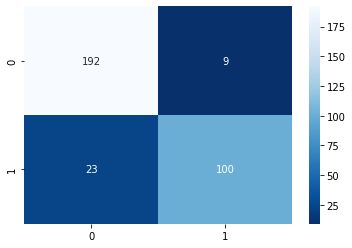

In [73]:
# построим матрицу ошибок
sns.heatmap(confusion_matrix(
    y_test_le, 
    random_search.best_estimator_.predict(X_test)), 
    annot=True, 
    fmt='d', 
    cmap='Blues_r'
    );

In [74]:
print(y_test.iloc[0], y_test_le[0])


Прежний уровень 0


Еденицей у нас закодировано значение - "снизилась", а нулем - "прежний уровень".

Из матрицы ошибок и метрик Precision = 0.917 и Recall = 0.813 видно, что модель модель хорошо справляется со своей задачей, но всё-таки у нее есть трудности с определением объектов класса "снизилась", этот факт подтверждает метрика Recall.

Обычно при увеличении одной из метрик Precision или Recall уменьшается другая. А в нашем случае нам важны обе метрики, так как мы не хотим пропустить пользователей у которых снижается уровень активности и не хотим делать дополнительные затраты на тех пользователей, у кого активность осталась прежней.

In [75]:
random_search.best_params_

{'selector__k': 8,
 'preprocessor__num': MinMaxScaler(),
 'models__n_neighbors': 15,
 'models__leaf_size': 10,
 'models__algorithm': 'kd_tree',
 'models': KNeighborsClassifier(algorithm='kd_tree', leaf_size=10, n_neighbors=15)}

В нашем коде, мы перебрали 6000 комбинаций для обучения моделей. Лучшей у нас оказалась модель **KNeighborsClassifier** с параметрами:
- *'models__n_neighbors'*: 15,
- *'models__leaf_size'*: 10,
- *'models__algorithm'*: 'kd_tree'
- скейлером *'StandardScaler'*
- количеством параметров 8

Далее мы будем использовать эту модель, чтобы оценить важность признаков.

## Анализ важности признаков

Будем оценивать важность признаков с помощью метода **SHAP**.

Для начала получим лучшую модель из RandomizedSearchCV.

In [75]:
best_model = random_search.best_estimator_.named_steps['models']
best_model

KNeighborsClassifier(algorithm='kd_tree', leaf_size=10, n_neighbors=15)

In [77]:
# преобразуем тестовую выборку для работы с лучшей моделью и использовании в инструментах библиотеки **shap**
X_test_preprocessed = random_search.best_estimator_.named_steps['preprocessor'].transform(X_test)
X_test_preprocessed_selected = random_search.best_estimator_.named_steps['selector'].transform(X_test_preprocessed)
X_test_preprocessed_selected = pd.DataFrame(X_test_preprocessed_selected, columns=random_search.best_estimator_.named_steps['selector'].get_feature_names_out(input_features=\
                        random_search.best_estimator_.named_steps['preprocessor'].get_feature_names_out()))

X_test_preprocessed_selected

,num__маркет_актив_6_мес,num__акционные_покупки,num__средний_просмотр_категорий_за_визит,num__неоплаченные_продукты_штук_квартал,num__страниц_за_визит,num__препредыдущий_месяц_выручка,num__предыдущий_месяц_минут,num__текущий_месяц_минут
0,0.561404,0.045455,1.0,0.1,0.578947,0.520128,0.611111,0.684211
1,0.087719,0.943182,0.4,0.6,0.263158,0.356550,0.333333,0.263158
2,0.421053,0.022727,0.6,0.2,0.473684,0.298403,0.833333,0.368421
3,0.456140,0.272727,0.6,0.3,0.263158,0.571885,0.222222,0.263158
4,0.807018,1.000000,0.0,0.2,0.315789,0.225559,0.555556,0.736842
...,...,...,...,...,...,...,...,...
319,0.000000,0.147727,0.2,0.5,0.157895,0.249201,0.333333,0.315789
320,0.526316,0.113636,0.4,0.0,0.684211,0.290735,0.555556,0.684211
321,0.263158,0.215909,0.4,0.5,0.105263,0.042812,0.444444,0.526316
322,0.543860,0.193182,0.6,0.0,0.421053,0.502875,0.500000,0.315789


In [78]:
# будем использвать класс KernelExplainer, так как лучшая модель у нас оказалась KNN
explainer = shap.KernelExplainer(
    best_model.predict, 
    X_test_preprocessed_selected,
    )

Using 324 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


In [79]:
shap_values = explainer.shap_values(X_test_preprocessed_selected)

  0%|          | 0/324 [00:00<?, ?it/s]

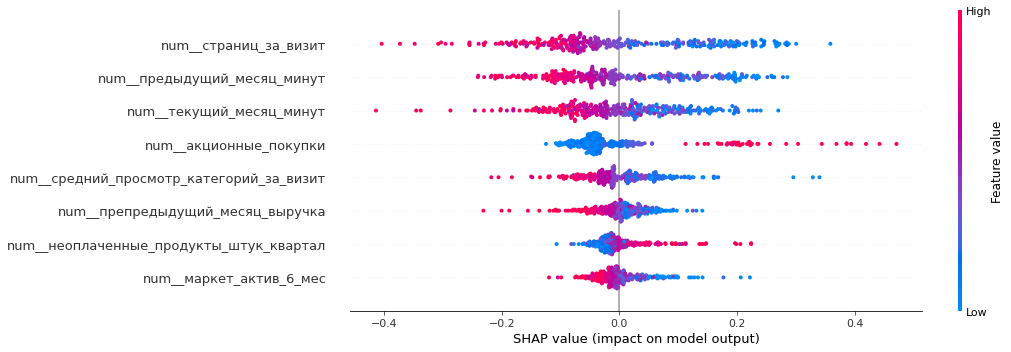

In [80]:
shap.summary_plot(shap_values, X_test_preprocessed_selected, plot_size=[15,5])

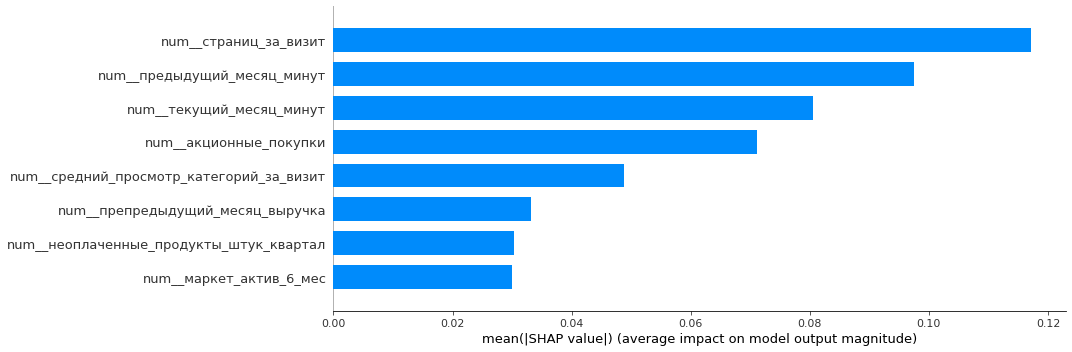

In [81]:
shap.summary_plot(shap_values, X_test_preprocessed_selected, plot_type="bar", plot_size=[15,5])

Напоминание: еденицей у нас закодировано значение - "снизилась"(1), а нулем - "прежний уровень"(0).

Так как на стадии сборки пайплайна мы внедрили в него инструмент **SelectKBest**, который на основе статистических тестов отбирает наиболее значимые признаки, то сейчас перед нами всего лишь 8 признаков из первоначальных 16(до кодировки).

Наиболее значимые признаки для модели:

1. **"страниц_за_визит"** , чем выше значение, тем выше вероятность объекта попасть в класс 0
2. **"предыдущий_месяц_минут"** , чем выше значение, тем выше вероятность объекта попасть в класс 0
3. **"текущий_месяц_минут"** , чем выше значение, тем выше вероятность объекта попасть в класс 0
4. **"акционные_покупки"** , чем выше значение, тем выше вероятность объекта попасть в класс 1 и чем ниже значение, тем выше вероятность принадлежности объекта к классу 0
5. **"средний_просмотр_категорий_за_визит"** , чем выше значение, тем выше вероятность объекта попасть в класс 0
6. **"препредыдущий_месяц_выручка"** , чем выше значение, тем выше вероятность объекта попасть в класс 0
7. **"неоплаченные_продукты_штук_квартал"** , чем выше значение, тем выше вероятность объекта попасть в класс 1
8. **"маркет_актив_6_мес"** , чем выше значение, тем выше вероятность объекта попасть в класс 0

Эти сведения можно использовать для дальнейших улучшений модели(моделей), например исключить избыточные признаки и сконцентрироваться на наиболее значимых для модели признаках, поработать над созданием новых синтетических признаков на основе имеющихся. Например, агрегировать одинаковые признаки за разные периоды.

Также с помощью этих наблюдений можно сформулировать новые гипотезы, дать рекоммендации по улучшению бизнес-процессов(на основе признаков для модели можно более детально проследить связь в реальной жизни между признаками и покупательской активностью пользователей).


## Анализ сегмента покупателей

Для анализа мы выбираем следующий сегмент покупателей - группа клиентов с максимальной долей покупок по акции и высокой вероятностью снижения покупательской активности.

На SHAP графиках видно, что значение признака **'акционные_покупки'** выше среднего практически во всех случаях определяет активность клиента как снизившуюся. Поэтому выделим этот сегмент покупателей, как записи где доля акционных покупок превышает 60%.



In [71]:
segment_to_analyze = data[data['акционные_покупки'] > 0.6]
print(segment_to_analyze.shape)
segment_to_analyze.head()

(166, 18)


,номер_покупателя,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,предыдущий_месяц_выручка,препредыдущий_месяц_выручка,текущий_месяц_выручка,предыдущий_месяц_минут,текущий_месяц_минут
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,5216.0,4472.0,4971.6,12,10
3,215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,6158.0,4793.0,6610.4,11,13
4,215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,5807.5,4594.0,5872.5,8,11
14,215362,Снизилась,премиум,да,4.2,4,438,0.74,Домашний текстиль,3,4,6,4,4314.0,4765.0,4447.9,13,13
16,215364,Снизилась,премиум,да,4.3,4,708,0.98,Домашний текстиль,3,3,3,3,5795.5,4942.0,5484.8,11,9


Также для анализа нам необходимо получить из лучшей модели вероятности принадлежности каждого клиента к классу активности "снизилась". Добавим столбец с вероятностями принадлежности в основную таблицу.

In [72]:
predictions = random_search.best_estimator_.predict_proba(
    data.drop(
        [
            'номер_покупателя',
            'покупательская_активность'
        ], 
				axis=1
    )
)
data['вероятность_принадлежности_к_классу_1'] = predictions[:, 1]
data

,номер_покупателя,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,предыдущий_месяц_выручка,препредыдущий_месяц_выручка,текущий_месяц_выручка,предыдущий_месяц_минут,текущий_месяц_минут,вероятность_принадлежности_к_классу_1
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,5216.0,4472.0,4971.6,12,10,0.866667
2,215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,5457.5,4826.0,5058.4,8,13,0.400000
3,215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,6158.0,4793.0,6610.4,11,13,0.666667
4,215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,5807.5,4594.0,5872.5,8,11,1.000000
5,215353,Снизилась,стандарт,да,3.3,4,762,0.26,Домашний текстиль,4,1,1,4,4738.5,5124.0,5388.5,10,10,0.666667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1295,216643,Прежний уровень,стандарт,да,6.6,3,318,0.24,Техника для красоты и здоровья,5,3,3,11,3664.0,4704.0,4741.7,14,7,0.066667
1296,216644,Прежний уровень,стандарт,нет,5.1,4,454,0.21,Домашний текстиль,6,2,3,9,4729.0,5299.0,5353.0,12,11,0.000000
1297,216645,Прежний уровень,стандарт,да,4.1,3,586,0.20,Домашний текстиль,3,2,5,7,5160.0,5334.0,5139.2,12,18,0.000000
1298,216646,Прежний уровень,стандарт,да,6.3,5,645,0.12,Техника для красоты и здоровья,3,3,5,7,4923.0,4725.0,5224.6,18,7,0.133333


Чтобы точнее выбрать сегмент, мы построим диаграмму рассеяния, где на одной оси будут лежать значения вероятности принадлежности к классу 1, а на другой — доля акционных покупок.

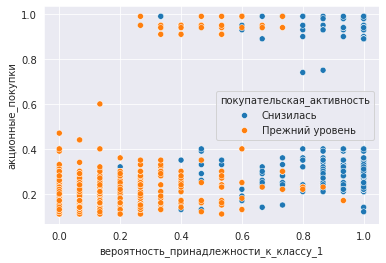

In [73]:
sns.set_style('darkgrid')
sns.scatterplot(
    data=data, 
    x="вероятность_принадлежности_к_классу_1", 
    y="акционные_покупки", 
    hue="покупательская_активность"
    );

Для исследования мы выберем сегмент с высокой долей акционных покупок и высокой вероятностью снижения активности. Доля акционных покупок свыше 60%, вероятность снижения активности выше 80%. При таких условиях мы получим сегмент в котором, в котором будут находиться пользователи принадлежащие к одному классу активности и со схожими значениями признака **"акционные_покупки"**. 

In [74]:
segment_to_analyze = data[(data['акционные_покупки'] > 0.6) & (data['вероятность_принадлежности_к_классу_1'] > 0.8)]
print(segment_to_analyze.shape)
segment_to_analyze.head()

(110, 19)


,номер_покупателя,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,предыдущий_месяц_выручка,препредыдущий_месяц_выручка,текущий_месяц_выручка,предыдущий_месяц_минут,текущий_месяц_минут,вероятность_принадлежности_к_классу_1
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,5216.0,4472.0,4971.6,12,10,0.866667
4,215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,5807.5,4594.0,5872.5,8,11,1.000000
16,215364,Снизилась,премиум,да,4.3,4,708,0.98,Домашний текстиль,3,3,3,3,5795.5,4942.0,5484.8,11,9,0.933333
17,215365,Снизилась,стандарт,да,3.9,4,167,0.95,Техника для красоты и здоровья,6,4,2,5,4577.0,4190.0,4799.3,6,10,0.866667
25,215373,Снизилась,премиум,нет,3.8,3,811,0.90,Товары для детей,2,5,5,3,4632.0,4293.0,5161.1,10,8,1.000000


Дополнительно рассчитаем выручку для каждого клиента за 3 периода и добавим в датасет сведения о прибыли магазина от каждого покупателя.

In [75]:
segment_to_analyze['выручка_за_3_последних_месяца_всего'] = segment_to_analyze['предыдущий_месяц_выручка'] + \
                                                                segment_to_analyze['препредыдущий_месяц_выручка'] + \
                                                                    segment_to_analyze['текущий_месяц_выручка']
segment_to_analyze.head(5)     

/tmp/ipykernel_48/3728109571.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  segment_to_analyze['выручка_за_3_последних_месяца_всего'] = segment_to_analyze['предыдущий_месяц_выручка'] + \


,номер_покупателя,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,предыдущий_месяц_выручка,препредыдущий_месяц_выручка,текущий_месяц_выручка,предыдущий_месяц_минут,текущий_месяц_минут,вероятность_принадлежности_к_классу_1,выручка_за_3_последних_месяца_всего
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,5216.0,4472.0,4971.6,12,10,0.866667,14659.6
4,215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,5807.5,4594.0,5872.5,8,11,1.000000,16274.0
16,215364,Снизилась,премиум,да,4.3,4,708,0.98,Домашний текстиль,3,3,3,3,5795.5,4942.0,5484.8,11,9,0.933333,16222.3
17,215365,Снизилась,стандарт,да,3.9,4,167,0.95,Техника для красоты и здоровья,6,4,2,5,4577.0,4190.0,4799.3,6,10,0.866667,13566.3
25,215373,Снизилась,премиум,нет,3.8,3,811,0.90,Товары для детей,2,5,5,3,4632.0,4293.0,5161.1,10,8,1.000000,14086.1


Теперь учитывая портрет покупателя, у которого снижается покупательская активность(который мы "обрисовали" на этапе исследовательского анализа), посмотрим на эти показатели в разрезе периодов, категорий товаров, также на показатели не связанные со временем.

Построим гистрограммы для наиболее важных числовых признаков и которые представлены в данных одним периодом:

In [76]:
num_cols_segment = [
    'страниц_за_визит',
    'средний_просмотр_категорий_за_визит',
    'маркет_актив_6_мес',
    'неоплаченные_продукты_штук_квартал',
]

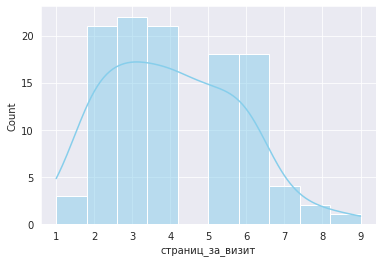

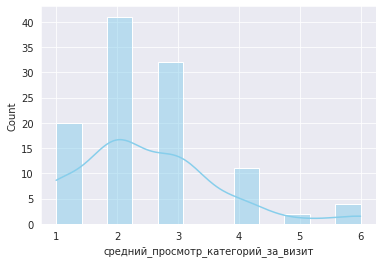

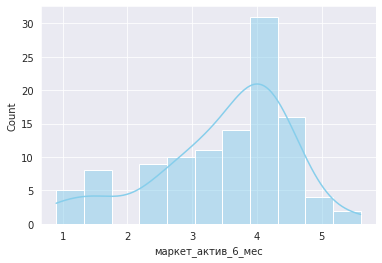

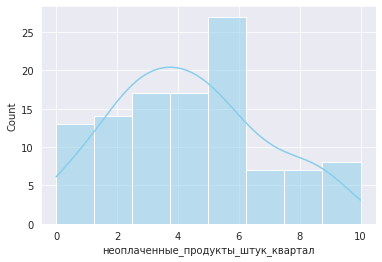

In [77]:
for col in num_cols_segment:
    sns.histplot(segment_to_analyze[col], kde=True, color='skyblue')
    plt.show()

Пользователь из нашего сегмента просматривает от 2 страниц до 6, в то время как для пользователей с прежним уровнем активности этот диапазон составляет от 5 до 14 страниц.

Значения среднего просмотра категорий находится от 1 до 3, а для пользователей противоположного класса этот диапазон составляет от 2 до 5.

Значения числа маркетинговых взаимодействий с пользователем из нашего сегмента лежит в диапазоне от 2 до 4, в то время как для пользователей противоположного класса этот диапазон составляет от 3 до 6.

Значения количества неоплаченных товаров в корзине у пользователей из нашего сегмента лежат в диапазоне от 0 до 6, в то время как для пользователей противоположного класса этот диапазон составляет также от 0 до 6. Значит для нашего сегмента значения этого признака совпдают с основной массой значений, как и у пользователей с прежним уровенм покупательской активности.

Теперь посотрим как меняется наша выручка в зависимости от периода.

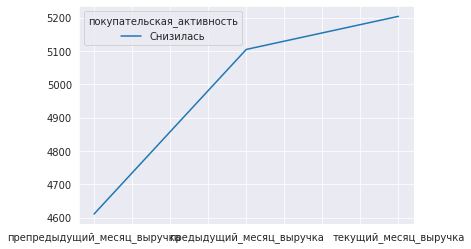

In [78]:
revenue_for_segment_by_period = segment_to_analyze.groupby(
    'покупательская_активность'
    ).agg(
        {
            'препредыдущий_месяц_выручка': 'median', 
            'предыдущий_месяц_выручка': 'median', 
            'текущий_месяц_выручка': 'median'
            }
            )

revenue_for_segment_by_period

revenue_for_segment_by_period.transpose().plot();

Для данного сегмента последовательно по периодам объем выручки увеличивается, но при этом покупательская активность снижается. Попробуем построить такие же графики для каждой категории.

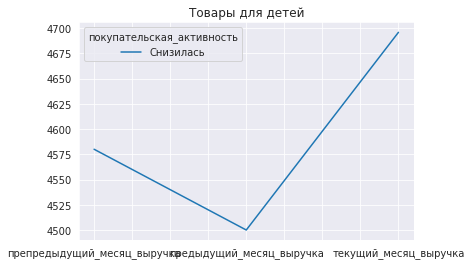

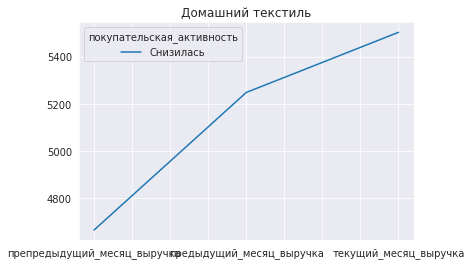

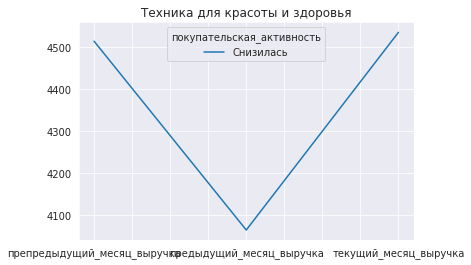

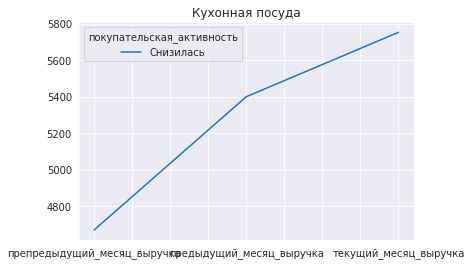

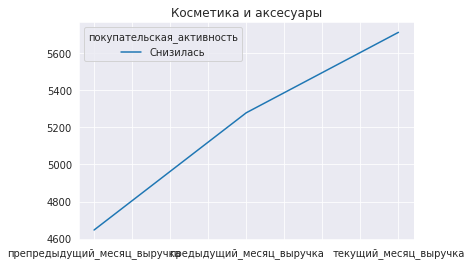

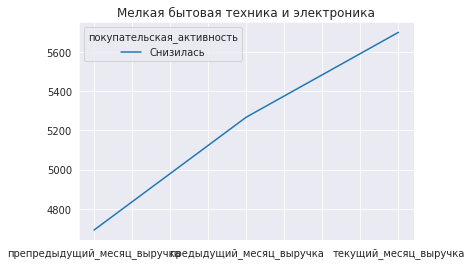

In [79]:
for category in segment_to_analyze['популярная_категория'].unique():
    segment_to_analyze_by_category = segment_to_analyze[segment_to_analyze['популярная_категория'] == category]
    revenue_for_segment_by_period = segment_to_analyze_by_category.groupby(
        'покупательская_активность'
        ).agg(
            {
                'препредыдущий_месяц_выручка': 'median', 
                'предыдущий_месяц_выручка': 'median', 
                'текущий_месяц_выручка': 'median'
                }
                )
    revenue_for_segment_by_period.transpose().plot(title=category);

Из этих графиков видно, что в разрезе периодов у нас по выручке "проседает" две категории товаров - "Товары для детей" и "Техника для красоты и здоровья". 

Теперь взглянем на абсолютное количество клиентов по каждой популярной категории.

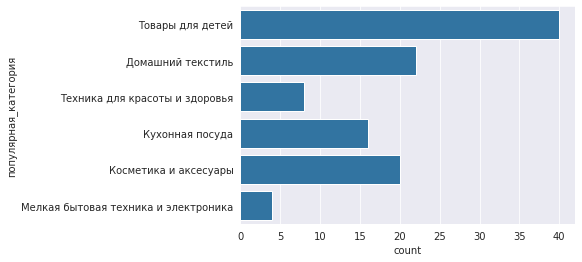

In [80]:
sns.set_style('darkgrid')
sns.countplot(
    data=segment_to_analyze, 
    y="популярная_категория", 
    );

Из оставшися признаков, связанных с предыдущим периодом у нас есть количесвто минут проведенных на площадке. Посомтрим как количесвто минут связано с выручкой за предыдущий период.

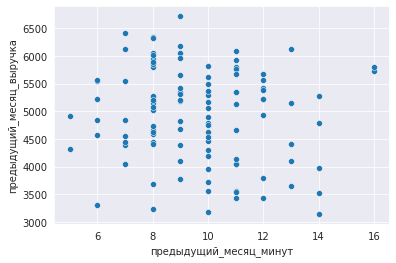

In [81]:
sns.set_style('darkgrid')
sns.scatterplot(
    data=segment_to_analyze, 
    x="предыдущий_месяц_минут", 
    y="предыдущий_месяц_выручка", 
    );

Из данного графика видно, что сильной связи для этих двух показателей и выбранного периода не наблюдается. Значит причину снижения выручки для этого периода и выбранных категорий на данном этапе отследить не представляется возможным. Узнаем тенденции по количеству проведенных минут пользователями из сегмента на площадке магазина.


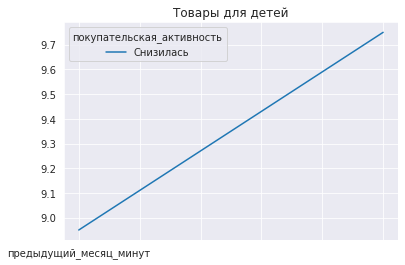

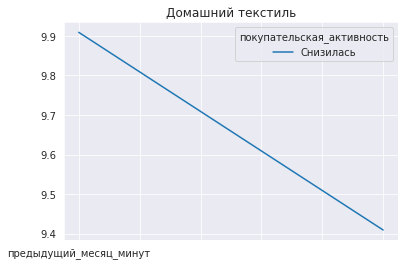

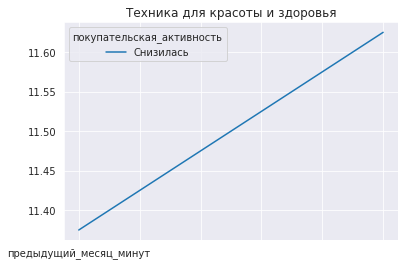

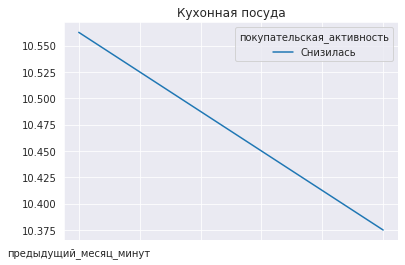

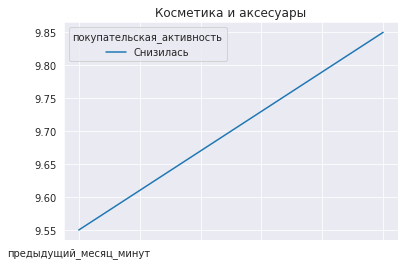

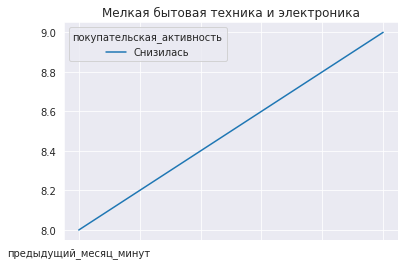

In [82]:
for category in segment_to_analyze['популярная_категория'].unique():
    segment_to_analyze_by_category = segment_to_analyze[segment_to_analyze['популярная_категория'] == category]
    minutes_for_segment_by_period = segment_to_analyze_by_category.groupby(
        'покупательская_активность'
        ).agg(
            {   
                'предыдущий_месяц_минут': 'mean', 
                'текущий_месяц_минут': 'mean'
                }
                )
    minutes_for_segment_by_period.transpose().plot(title=category);

Из данных графиков можно сделать вывод о том, что для "проседающих" категорий для текущего месяца выручка выросла вместе с количеством минут на площадке для этих категорий.

Из всего проделанного анализа озвучим следующие рекомендации по повыушению покупателськой активнсоти для данного сегмента:

1. В целом нужны меры, направленные на повышение времени взаимодействия покупателя с магазином, так как такие показатели, например как, минуты проведенные на сайте, количество просмотренных категорий за визит имеют значения ниже чем у пользователей с прежней активностью. У большинства пользователей нашего сегмента включены дополнительные уведомления от магазина, поэтому мы можем чаще присылать им какую-то дополнительную информацию и увеличить количество маркетинговых взаимодейтсвий с ними в целом.

2. Также возможно пересмотреть систему скидок для категорий, по которым в предыдущем периоде снижалась выручка.

3. Для пользователей у которых в корзине находится более 6 неоплаченных товаров предлагать дополнительные бонусы или присылать "приглашения"/"уведомления" о том что у них имеются товары в корзине и на на них действуют скидки.

ПЕРВАЯ ВЕРСИЯ НИЖЕ

Дополнительно рассчитаем выручку для каждого клиента за 3 периода и добавим в датасет сведения о прибыли магазина от каждого покупателя.

In [83]:
segment_to_analyze['выручка_за_3_последних_месяца_всего'] = segment_to_analyze['предыдущий_месяц_выручка'] + \
                                                                segment_to_analyze['препредыдущий_месяц_выручка'] + \
                                                                    segment_to_analyze['текущий_месяц_выручка']
segment_to_analyze.head(5)                                                                    

/tmp/ipykernel_48/1819943317.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  segment_to_analyze['выручка_за_3_последних_месяца_всего'] = segment_to_analyze['предыдущий_месяц_выручка'] + \


,номер_покупателя,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,предыдущий_месяц_выручка,препредыдущий_месяц_выручка,текущий_месяц_выручка,предыдущий_месяц_минут,текущий_месяц_минут,вероятность_принадлежности_к_классу_1,выручка_за_3_последних_месяца_всего
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,5216.0,4472.0,4971.6,12,10,0.866667,14659.6
4,215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,5807.5,4594.0,5872.5,8,11,1.000000,16274.0
16,215364,Снизилась,премиум,да,4.3,4,708,0.98,Домашний текстиль,3,3,3,3,5795.5,4942.0,5484.8,11,9,0.933333,16222.3
17,215365,Снизилась,стандарт,да,3.9,4,167,0.95,Техника для красоты и здоровья,6,4,2,5,4577.0,4190.0,4799.3,6,10,0.866667,13566.3
25,215373,Снизилась,премиум,нет,3.8,3,811,0.90,Товары для детей,2,5,5,3,4632.0,4293.0,5161.1,10,8,1.000000,14086.1


In [84]:
segment_to_analyze = segment_to_analyze.merge(money_df, on='номер_покупателя', how='left')
print(segment_to_analyze.shape)
segment_to_analyze.head()

(110, 21)


,номер_покупателя,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,...,ошибка_сервиса,страниц_за_визит,предыдущий_месяц_выручка,препредыдущий_месяц_выручка,текущий_месяц_выручка,предыдущий_месяц_минут,текущий_месяц_минут,вероятность_принадлежности_к_классу_1,выручка_за_3_последних_месяца_всего,прибыль
0,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,...,2,5,5216.0,4472.0,4971.6,12,10,0.866667,14659.6,4.16
1,215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,...,3,2,5807.5,4594.0,5872.5,8,11,1.000000,16274.0,4.21
2,215364,Снизилась,премиум,да,4.3,4,708,0.98,Домашний текстиль,3,...,3,3,5795.5,4942.0,5484.8,11,9,0.933333,16222.3,2.67
3,215365,Снизилась,стандарт,да,3.9,4,167,0.95,Техника для красоты и здоровья,6,...,2,5,4577.0,4190.0,4799.3,6,10,0.866667,13566.3,3.65
4,215373,Снизилась,премиум,нет,3.8,3,811,0.90,Товары для детей,2,...,5,3,4632.0,4293.0,5161.1,10,8,1.000000,14086.1,3.69


Выделим числовые и категориальные столбцы необходимые для исследования. В числовые признаки возьмем наиболее влияющие на целевой признак.

In [85]:
num_cols_segment = [
    'страниц_за_визит',
    'предыдущий_месяц_минут',
    'текущий_месяц_минут',
    'акционные_покупки',
    'средний_просмотр_категорий_за_визит',
    'выручка_за_3_последних_месяца_всего',
    'маркет_актив_6_мес',
    'неоплаченные_продукты_штук_квартал',
    'прибыль'
]

cat_cols_segment = [
    'покупательская_активность',
    'тип_сервиса',
    'разрешить_сообщать',
    'популярная_категория'
]

Посмотрим как связаны между собой доля покупок по акции, покупательская активность и остальные важные признаки.

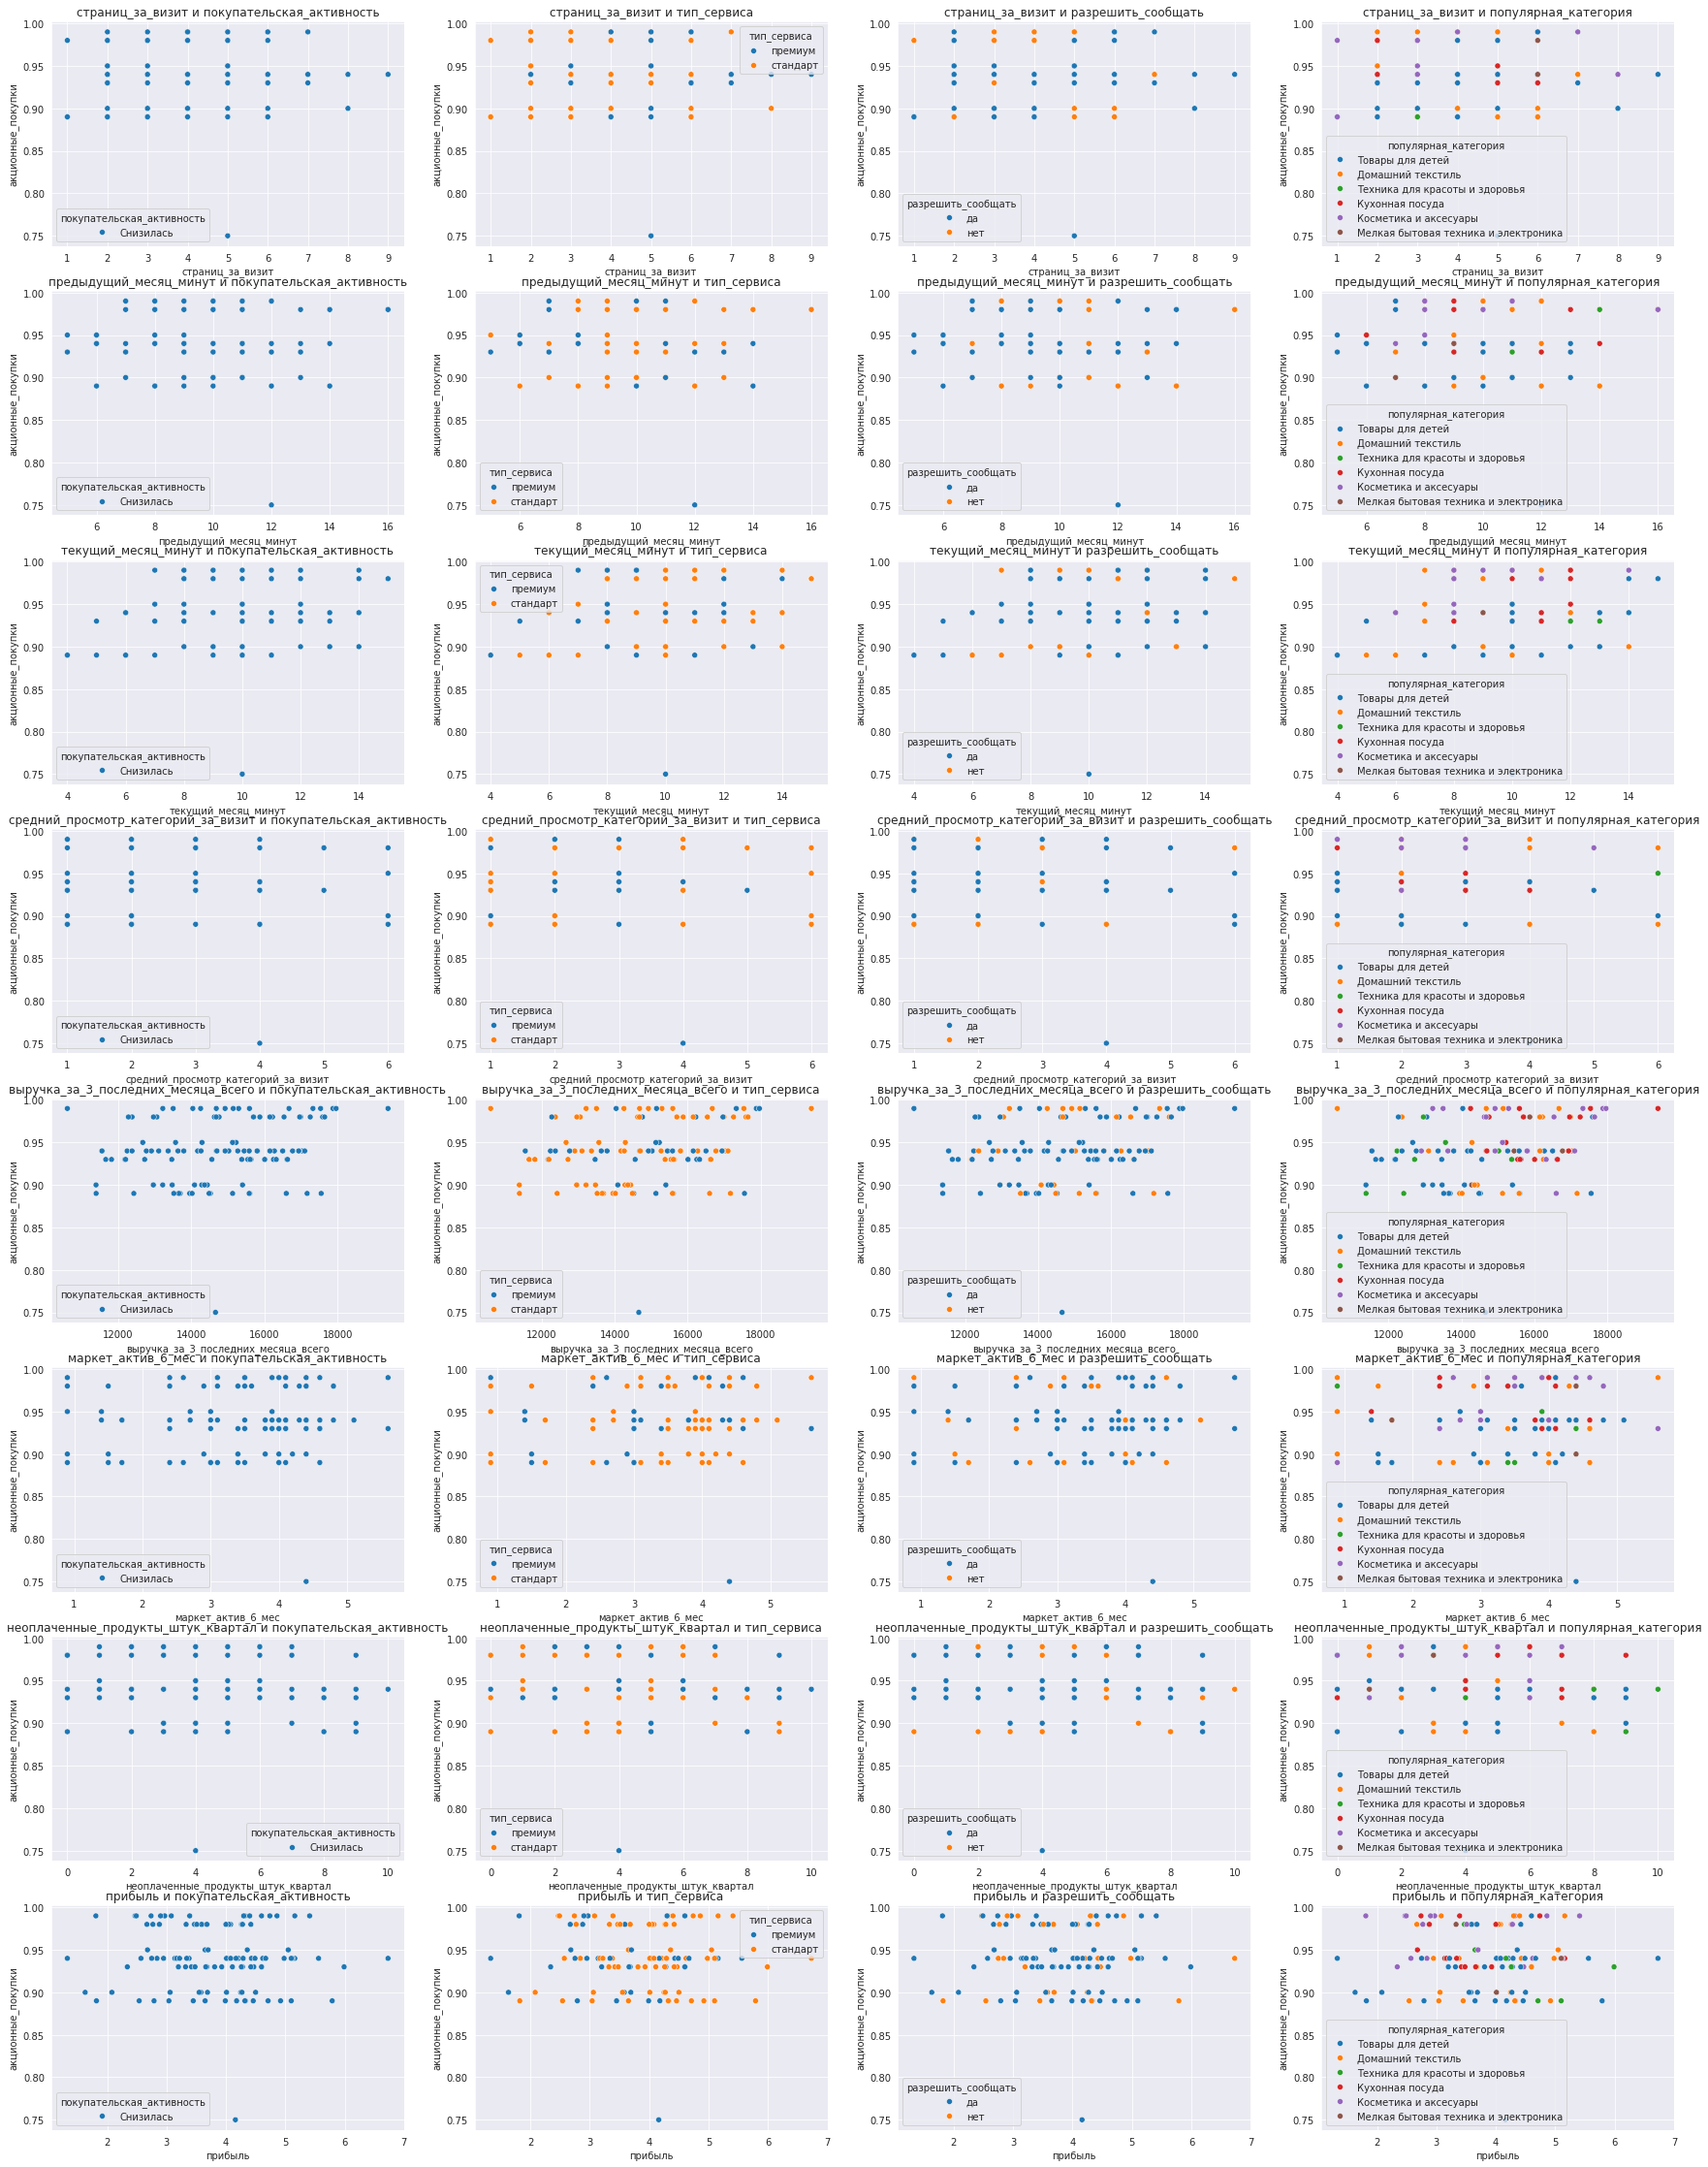

In [86]:
fig, axs = plt.subplots(len(num_cols_segment)-1, len(cat_cols_segment), figsize=(30, 40))

for a, num_col in enumerate([x for x in num_cols_segment if x != "акционные_покупки"]):
    for b, cat_col in enumerate(cat_cols_segment):
        sns.set_style('darkgrid')
        sns.scatterplot(data=segment_to_analyze, x=num_col, y="акционные_покупки", hue=cat_col, ax=axs[a, b]);
        axs[a, b].set_title(f"{num_col} и {cat_col}")

Из графиков выше можно выделить следущие закономерности:

- чем больше страниц просматривает пользователь за визит, тем выше шанс его принадлежности к классу активности "прежний уровень". **Это повод для дополнительных исследований, необходимо посомтреть на то как меняется выручка и прибыль в зависимости от количества просмотренных страниц.** Так как "смотреть" не равно "купить".

- объем выручки за последние 3 месяца не оказывает видимого влияния на принадлежность к определнному классу активности.

- а вот маркетинговая активность за шесть месяцев имеет влияние на покупательскую активность: меньше 3 маркетинговых взаимодействий с клиентами, покупающими товары по акции практически гарантировано снижают покупательскую активность этих клиентов.

- с увеличением количества неоплаченных товаров в корзине, так же растет шанс принадлежности к классу активности "снизилась"

- тип сервиса практически ни на что не влияет, как минимум на данных графиках это незаметно

- разрешение для дополнительных уведомлений также не образует каких-то групп(связей) на наших графиках

- графики с категориями тоже малоинформативны

Попробуем провести дополнительное исследование, чтобы посомтреть как связаны выручка/прибыль с количеством просомтренных страниц.

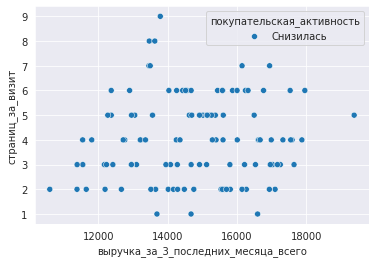

In [87]:
sns.set_style('darkgrid')
sns.scatterplot(
    data=segment_to_analyze, 
    x="выручка_за_3_последних_месяца_всего", 
    y="страниц_за_визит", 
    hue="покупательская_активность"
    );

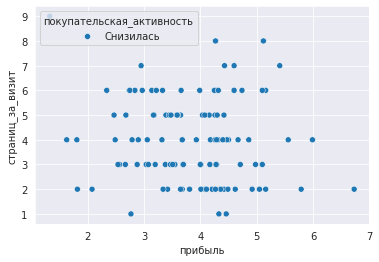

In [88]:
sns.set_style('darkgrid')
sns.scatterplot(
    data=segment_to_analyze, 
    x="прибыль", 
    y="страниц_за_визит", 
    hue="покупательская_активность"
    );

Два графика выше не дали нам какой-то дополнительной информации. Выручка и прибыль могут иметь одинаково высокие показатели для двух классов активности.

Посмотрим на тенденцию изменнения выручки по периодам в этом сегменте. Сделаем сводную таблицу для этого.

In [89]:
revenue_for_segment_by_period = segment_to_analyze.groupby(
    'покупательская_активность'
    ).agg(
        {
            'препредыдущий_месяц_выручка': 'median', 
            'предыдущий_месяц_выручка': 'median', 
            'текущий_месяц_выручка': 'median'
            }
            )

revenue_for_segment_by_period

,препредыдущий_месяц_выручка,предыдущий_месяц_выручка,текущий_месяц_выручка
покупательская_активность,,,
Снизилась,4610.5,5104.5,5203.85


<AxesSubplot:>

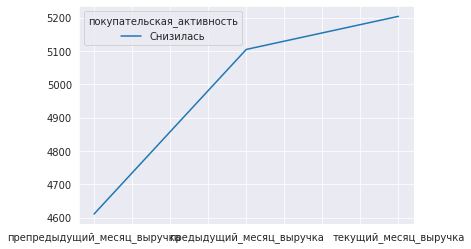

In [90]:
revenue_for_segment_by_period.transpose().plot()

Данный график тоже показывает противоречивые вещи, так как на нем видна тенденция роста выручки, что должно говорить о повышении покупательской активности.

Из этого всего, можно предложить следующие шаги для работы с данным сегментом:

- пересмотреть алгоритм работы маркетинговых взаимодействий, так как из графиков видно, что есть пользователи у которых разрешены оповещения, но с ними было произведено минимум маректинговых взаимодейтвий и их покупательская активность снизилась. Хотя пользователи позволяющие присылать дополнительные оповещения уже сигнализируют о том, чт они открыты к взаимодействию.
- есть пользователи у которых мало просмотренных страниц за визит, но такая же по размеру выручка, как от пользователей, которые смотрят больше страниц за визит: при этом всем в данном сегменте, количество пользователей у которых разрешены оповещения более чем в два раза многочисленнее, чем с отключенными оповещениями. Поэтому отдельное внимание стоит уделить пользователям у которых мало просмотренных страниц за визит.
- также стоит ввести дополнительные показатели(или показатель), который будет показывать сэкономленную сумму от общей потраченной суммы, чтобы оценить роль скидки и ее влияние: чисто психологическое или все-таки экономическое.

In [91]:
segment_to_analyze['разрешить_сообщать'].value_counts().to_frame()

,разрешить_сообщать
да,82
нет,28


## Общий вывод

### Первостепенные задачи в нашем проекте были следующие:
- на основе собранных данных, построить модель, которая будет предсказывать покупательскую активность
- после создания модели, необходимо было провести анализ признаков, понять какие факторы больше всего влияют на покупательскую активность
- далее необходимо было выделить сегмент клиентов, провести в нем исследования на основе всех собранных и полученных данных
- на основе исследования по сегменту - сделать предложения по проведению дейтсвий, направленных на увеличение покупательской активности в сегменте

### Этап предобработки данных
В наше распоряжение было получено четыре датафрейма:

1. `market_file_df` - таблица, которая содержит данные о поведении покупателя на сайте
2. `market_money_df` - таблица с данными о выручке, которую получает магазин с покупателя
3. `market_time_df` - таблица с данными о времени (в минутах), которое покупатель провёл на сайте
4. `money_df` - таблица с данными о среднемесячной прибыли продавца за последние 3 месяца: какую прибыль получает магазин от продаж каждому покупателю

Проделанные действия:
- во всех датафреймах мы изменили названия столбцов в соответсвии c нормами именования столбцов/переменных
- в `money_df` мы изменили тип столбца **'прибыль'** с *object* на *float64*
- в столбце **"тип_сервиса"** датафрейма `market_file_df` был неявный дубликат с одинаковым по смыслу значению, но разным по написанию - "стандарт" и "стандартт", мы испарвили это
- дубликаты отсутствовали в наших датафреймах

### Поиск лучшей модели

Чтобы найти лучшую модель, мы предприняли следующие шаги:

1. Сделали пайплайн для подготовки данных к обучению, где производится кодирование категориальных признаков, а также мастштабирование числовых признаков
2. Далее мы сделали финальный пайплайн, куда поместили пайплайн для подготовки данных, инструмент *SelectKBest* для отбора признаков, а также базовую модель *DecisionTreeClassifier*.
3. Разделили данные с учетом того что имеется дисбаланс классов.
4. Вручную, до применения пайплайна закодировали целевой признак с помощью *LabelEncoder*.
5. Создали словарь с моделями, которые будем обучать и их гиперпараметрами. Модели к обучению:
    - KNeighborsClassifier
    - DecisionTreeClassifier
    - SVC
    - LogisticRegression
6. Используя пайплайн, словарь с моделями и их гиперпараметрами мы провели поиск лучшей модели и ее лучшего набора гиперпараметров, а также лучшего набора входных признаков. Для поиска мы использовали *RandomizedSearchCV* с параметром *n_iter=6000*, кросс-валидацией на 5 фолдов и метрикой *roc_auc*. Выбор метрики мы обосновывали [здесь](#1).

Лучшей у нас оказалась модель **KNeighborsClassifier** с параметрами:
- *'models__n_neighbors'*: 15,
- *'models__leaf_size'*: 10,
- *'models__algorithm'*: 'kd_tree'
- скейлером *'StandardScaler'*
- количеством параметров 8

После определения лучшей модели, мы провели SHAP анализ для неё. По результатам SHAP анализа мы выделили следующие важные признаки и их особенности: 

1. **"страниц_за_визит"** , чем выше значение, тем выше вероятность объекта попасть в класс 0
2. **"предыдущий_месяц_минут"** , чем выше значение, тем выше вероятность объекта попасть в класс 0
3. **"текущий_месяц_минут"** , чем выше значение, тем выше вероятность объекта попасть в класс 0
4. **"акционные_покупки"** , чем выше значение, тем выше вероятность объекта попасть в класс 1 и чем ниже значение, тем выше вероятность принадлежности объекта к классу 0
5. **"средний_просмотр_категорий_за_визит"** , чем выше значение, тем выше вероятность объекта попасть в класс 0
6. **"препредыдущий_месяц_выручка"** , чем выше значение, тем выше вероятность объекта попасть в класс 0
7. **"неоплаченные_продукты_штук_квартал"** , чем выше значение, тем выше вероятность объекта попасть в класс 1
8. **"маркет_актив_6_мес"** , чем выше значение, тем выше вероятность объекта попасть в класс 0

Для дополнительного исследования мы выбрали сегмент пользователей у которых высокая доля акционных товаров от общего количества покупок и высокая вероятность снижения покупательской активности. По результатам исследования мы сформулировали следующие предложения для сегмента и вообще в целом.

Для сегмента:

- В целом нужны меры, направленные на повышение времени взаимодействия покупателя с магазином, так как такие показатели, например как, минуты проведенные на сайте, количество просмотренных категорий за визит имеют значения ниже чем у пользователей с прежней активностью. У большинства пользователей нашего сегмента включены дополнительные уведомления от магазина, поэтому мы можем чаще присылать им какую-то дополнительную информацию и увеличить количество маркетинговых взаимодейтсвий с ними в целом.

- Также возможно пересмотреть систему скидок для категорий, по которым в предыдущем периоде снижалась выручка.

- Для пользователей у которых в корзине находится более 6 неоплаченных товаров предлагать дополнительные бонусы или присылать "приглашения"/"уведомления" о том что у них имеются товары в корзине и на на них действуют скидки.

В целом:

- анализ признаков можно использовать для дальнейших улучшений модели(моделей), например исключить избыточные признаки и сконцентрироваться на наиболее значимых для модели признаках, поработать над созданием новых синтетических признаков на основе имеющихся. Например, агрегировать одинаковые признаки за разные периоды.

- также стоит ввести дополнительные показатели(или показатель), который будет показывать сэкономленную сумму от общей потраченной суммы, чтобы оценить роль скидки и ее влияние: чисто психологическое или все-таки экономическое.

- пересмотреть подход к маркировке покупательской активности, возможно лучше определить критерии, которые определяют эту самую активность. Так как тенденция роста выручки сохраняется по периодам(!даже для класса активности "снизилась").